# Notebook 42: Second Wind Model - with fixes on fixes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path

import astropy.constants as ct
import astropy.units as u

import mesa_reader as mr

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [3]:
nb_id = 42

In [4]:
CODE_ROOT = Path('/mnt/home/ldesa/repos/cher')
DATA_ROOT = Path('/mnt/ceph/users/ldesa/mesa_che_grids')
PROJECT_FOLDER = DATA_ROOT/'sse_fiducial'
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [5]:
plt.style.use('./plotstyle.mplstyle')

In [6]:
Z_SUN = 0.014

### Utilities

In [7]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [8]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [9]:
def get_model_folder(model_id, verbose=True):
    """Finds model folder given its id."""
    matches = list(PROJECT_FOLDER.glob(f'{model_id}_*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [10]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        m, w = model_folder.name.replace('d', 'e').split('_')        
        m = f'{float(m.lstrip("m")):.1f}'
        w = float(w.lstrip('w'))
        p = 2*np.pi / w / (60*60*24)
        p = f'{p:.2f}'
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [11]:
def mesareader_operator(expression):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication, division and exp10."""
    operations = ['+', '-', '*', '/', '^', 'E', '(', ')', ',']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'h.__getattr__("{char}'
        else:
            if char == '^':
                char = '10**'
            elif char == 'E':
                char = 'gamma_e('
            mr_expression += f'{char}h.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        if char == '^':
            char = '10**'
        elif char == 'E':
                char = 'gamma_e('
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


### Plotting

In [12]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
            except:
                print(f'Model {model_path} failed to load.')
                continue
            else:
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    #else:
        #for ls, label in zip(model_styles, model_labels):
         #   handles.append(Line2D([], [], color='k', ls=ls, label=label))
    if label_period:
        ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
    
    return ax

In [13]:
def log_l_const_rad(log_teff, r):
    teff = 10.**log_teff * u.K
    r = fix_unit(r, u.Rsun)
    log_l = np.log10(4*np.pi*ct.sigma_sb * teff**4 * r**2 / u.Lsun)
    return log_l
log_l_const_rad = np.vectorize(log_l_const_rad)

In [14]:
def hd_limit(log_teff):
    teff = 10**log_teff * u.K
    log_l = (
        np.log10(1.e5*np.sqrt(4*np.pi))
        + 0.5*np.log10(ct.sigma_sb * u.Rsun**2 * teff**4 / u.Lsun)
    ).value
    log_l = max(log_l, np.log10(6.e5))
    return log_l
hd_limit = np.vectorize(hd_limit)

In [15]:
def hr_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        y='log_L',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

    # GUIDELINES
    
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    ## Humphreys-Davidson limit and LBV regime
    hd_x = np.linspace(*xlim, 100)
    hd_y = hd_limit(hd_x)
    ax.plot(hd_x, hd_y, 'k--', lw=1)
    ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)

    ## Lines of constant radius
    r_to_plot = np.concatenate((np.arange(0.5, 1, 0.1), np.arange(1, 10, 1), np.arange(10, 40, 10)))
    for i, r in enumerate(r_to_plot):
        r_y = log_l_const_rad(hd_x, r)
        ax.plot(hd_x, r_y, 'k--', lw=0.5, alpha=0.5)
        
        # label every two lines
        if not i%2:
            rotation = -np.arctan((r_y[10]-r_y[0])/(hd_x[10]-hd_x[0]))/np.pi*180       
            r_y_ = r_y[(hd_x >= xlim[1]) & (hd_x <= xlim[0])]
            y = r_y_[np.argmin(np.abs(r_y_-ylim[1]))]     
            x = hd_x[np.argmin(np.abs(r_y-y))]
            if (x < max(xlim) and x > min(xlim)) and (y < max(ylim) and y > min(ylim)):
                ax.text(
                    x, 
                    y,
                    f'${r:.1f}\\,\\mathrm{{R}}_\\odot$',
                    rotation=rotation,
                    ha='left',
                    va='top', 
                    fontsize=6,
                    alpha=0.8
                    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return ax

For now we only have models with mass variations, where all other settings fixed. These are $\delta_\mathrm{mesh}=1$, $Z=\mathrm{Z}_\odot/10$, $Y_0=0.4$ and $\delta Y=0.3$.

In [16]:
model_ids = np.arange(6, 8, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial/006_test_m40_fixfixfix
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial/007_test_m200_fixfixfix


Let's check the stellar models available.

In [17]:
print('Available models:')
for i in range(len(model_ids)):
    print(f'\t{model_folders[i]}:')
    keys1 = list(model_dicts[i].keys())
    keys1 = np.array(keys1)[np.argsort([float(key) for key in keys1])]
    for key1 in keys1:
        keys2 = list(model_dicts[i][key1].keys())
        keys2 = np.array(keys2)[np.argsort([float(key) for key in keys2])]
        print(f'\t\t(m1/msun) {key1}:')
        for key2 in keys2:
            print(f'\t\t\t(p_orb/d) {key2}')

Available models:
	/mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial/006_test_m40_fixfixfix:
		(m1/msun) 40.0:
			(p_orb/d) 0.35
			(p_orb/d) 0.40
			(p_orb/d) 0.45
			(p_orb/d) 0.50
			(p_orb/d) 0.55
			(p_orb/d) 0.60
			(p_orb/d) 0.65
			(p_orb/d) 0.70
			(p_orb/d) 0.75
			(p_orb/d) 0.80
			(p_orb/d) 0.85
			(p_orb/d) 0.90
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.20
			(p_orb/d) 1.30
			(p_orb/d) 1.40
			(p_orb/d) 1.50
			(p_orb/d) 1.60
			(p_orb/d) 1.70
			(p_orb/d) 1.80
			(p_orb/d) 1.90
			(p_orb/d) 2.00
			(p_orb/d) 2.10
			(p_orb/d) 2.20
			(p_orb/d) 2.30
			(p_orb/d) 2.40
			(p_orb/d) 2.50
			(p_orb/d) 2.60
			(p_orb/d) 2.80
			(p_orb/d) 3.00
			(p_orb/d) 3.20
			(p_orb/d) 3.40
			(p_orb/d) 3.60
			(p_orb/d) 3.80
			(p_orb/d) 4.00
	/mnt/ceph/users/ldesa/mesa_che_grids/sse_fiducial/007_test_m200_fixfixfix:
		(m1/msun) 200.0:
			(p_orb/d) 0.35
			(p_orb/d) 0.40
			(p_orb/d) 0.45
			(p_orb/d) 0.50
			(p_orb/d) 0.55
			(p_orb/d) 0.60
			(p_orb/d) 0.65
			(p_orb/d) 0.70
		

In [18]:
from matplotlib.lines import Line2D

import sys
sys.path.append('..')
from src.star import fix_unit

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


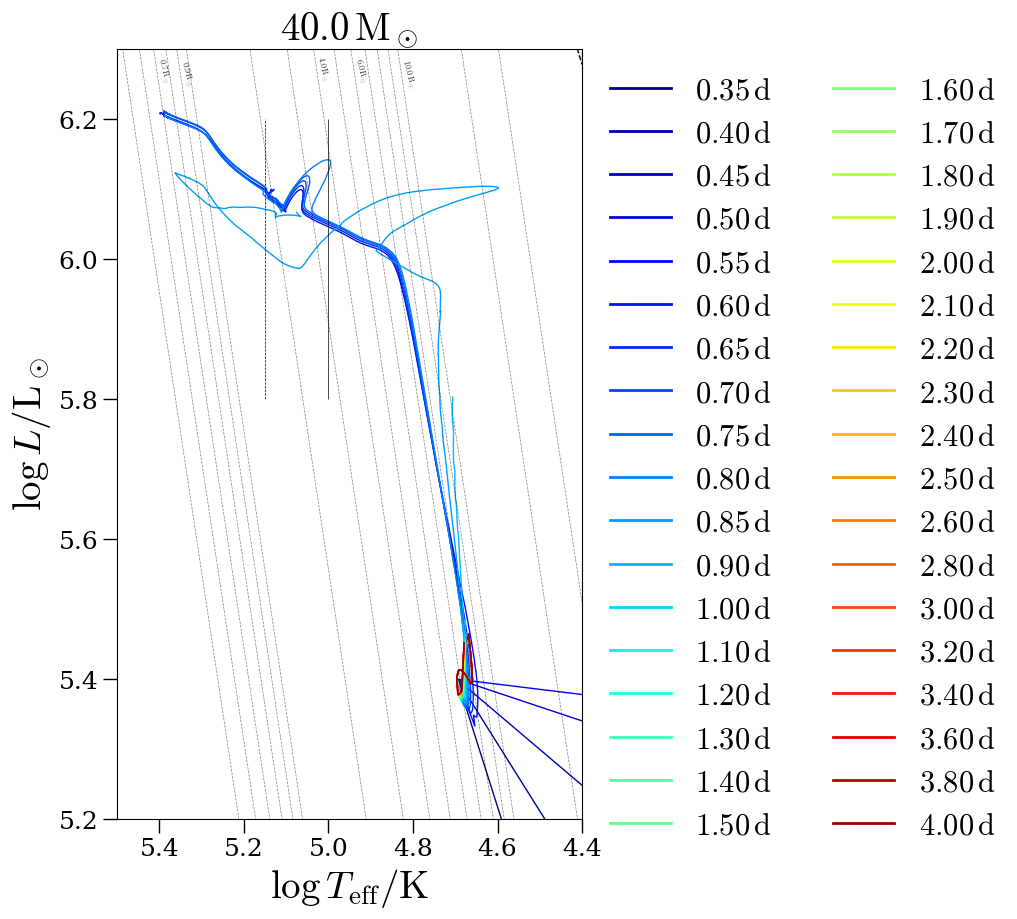

In [19]:
fig, ax = plt.subplots(figsize=(6, 10))
test_m = '40.0'

models_to_plot = [0]
model_style_list = ['-']
xlim = (5.5, 4.4)
ylim = (5.2, 6.3)
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')
ax.vlines(5, 5.8, 6.2, color='k', linestyles='-', linewidth=0.5)
ax.vlines(np.log10(1.41e5), 5.8, 6.2, color='k', linestyles='--', linewidth=0.5)


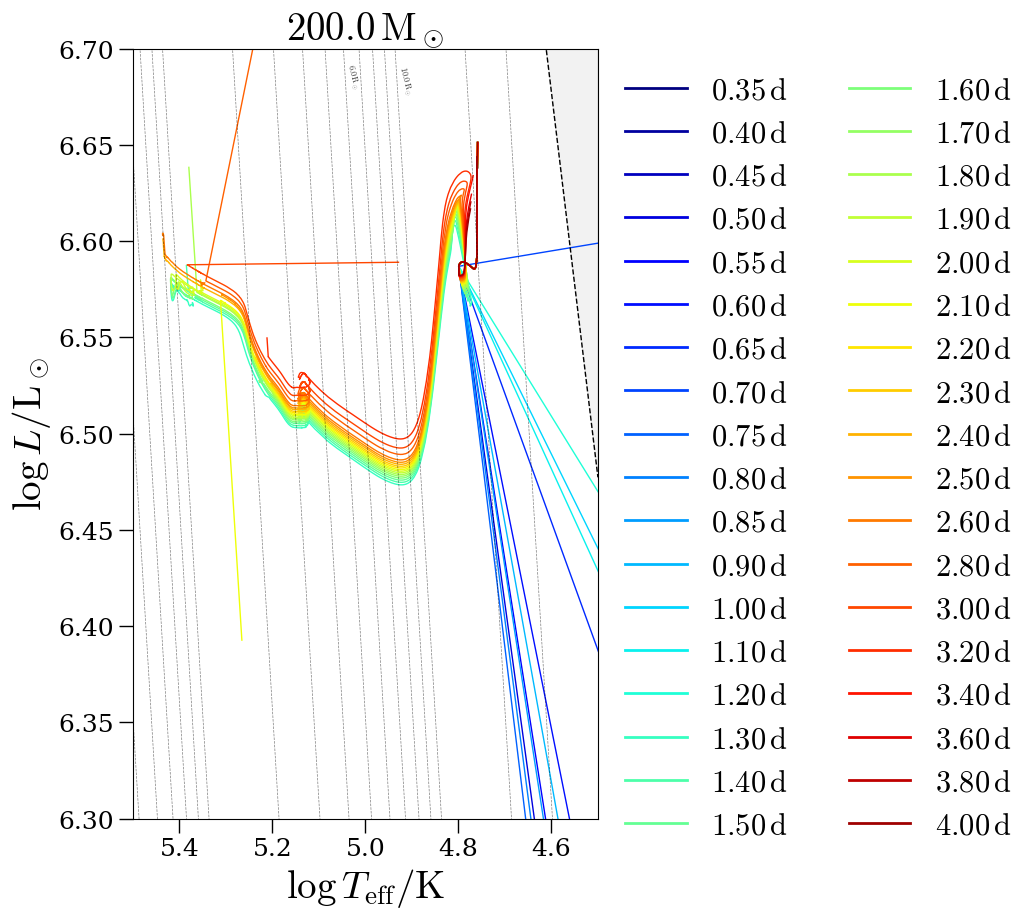

In [20]:
fig, ax = plt.subplots(figsize=(6, 10))
test_m = '200.0'

models_to_plot = [1]
model_style_list = ['-']
xlim = (5.5, 4.5)
ylim = (6.3, 6.7)
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')
ax.vlines(5.15, 5.8, 6.2)

| Abbreviation | Meaning |
|-----------------|-----------------|
| MS  | Main Sequence  |
| VMS  | Very Massive Main Sequence ($>100\,\mathrm{M}_\odot$)  |
| WR  | Wolf-Rayet  |
| lWR | low-luminosity Wolf-Rayet |
| hWR | high-luminosity Wolf-Rayet |
| CHE | Chemically Homogeneous Evolution |

In [21]:
def edd_gamma(x, l, m):
    return 10**-4.813 * (1+x) * l/m

def vink2001_w(l, m, teff, z):
    teff_jump = 61.2 + 2.59*(-13.636+0.889*np.log10(z/Z_SUN))
    dteff_jump = 100
    
    if teff > 27.5e3:
        a = 1
    elif teff < 22.5e3:
        a = 0
    else:
        if teff > teff_jump+dteff_jump:
            a = 1
        elif teff < teff_jump-dteff_jump:
            a = 0
        else:
            a = (teff-(teff_jump-dteff_jump))/(2*dteff_jump)
    
    if a > 0:
        vinf_div_vesc = 2.6*(z/Z_SUN)**0.13
        log_mdot = (-6.697
                    +2.194*np.log10(l/1e5)
                    -1.313*np.log10(m/30)
                    -1.226*np.log10(vinf_div_vesc/2)
                    +0.933*np.log10(teff/4e4)
                    -10.92*np.log10(teff/4e4)**2
                    +0.85*np.log10(z/Z_SUN))
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
    
    if a < 1:
        vinf_div_vesc = 1.3*(z/Z_SUN)**0.13
        log_mdot = (-6.688
                    +2.210*np.log10(l/1e5)
                    -1.339*np.log10(m/30)
                    -1.601*np.log10(vinf_div_vesc/2)
                    +1.07*np.log10(teff/4e4)
                    +0.85*np.log10(z/Z_SUN))
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0

    w = a*mdot1 + (1-a)*mdot2
    return w

def bjorklund2021_w(l, m, teff, z, x):
    g_e = edd_gamma(x, l, m)
    meff = (1-g_e)*m
    log_mdot = (-5.52
                +2.39*np.log10(l/1e6)
                -1.48*np.log10(meff/45)
                +2.12*np.log10(teff/4.5e4)
                +(0.75
                  -1.87*np.log10(teff/4.5e4)) * np.log10(z/Z_SUN))
    w = 10.**log_mdot 
    return w

def krticka2018_w(l, z):
    log_mdot = (-5.7
                +0.5*np.log10(z/Z_SUN)
                +(1.61 - 0.12*np.log10(z/Z_SUN)) * np.log10(l/1e6)
                )
    w = 10.**log_mdot
    return w

def sabhahit2023_switch_g(z):
    l = sabhahit2023_switch_l(z)
    m = sabhahit2023_switch_m(z)
    return 2.5e-5 * l/m

def sabhahit2023_switch_l(z):
    return 10.**2.36 * z**-1.91

def sabhahit2023_switch_m(z):
    return 0.0615 * z**-1.574 + 18.1

def vink2011_w(l, m, z):
    logmdot_switch = -1.86*np.log10(z) - 8.9
    l_switch = sabhahit2023_switch_l(z)
    m_switch = sabhahit2023_switch_m(z)
    w = 10.**logmdot_switch * (l/l_switch)**4.77 * (m/m_switch)**-3.99
    return w

def sabhahit2023_w(l, m, teff, z, x):
    g_e = edd_gamma(x, l, m)
    g_e_switch = sabhahit2023_switch_g(z)
    dg_e = 0.01
    
    if g_e > g_e_switch+dg_e:
        a = 1
    elif g_e < g_e_switch-dg_e:
        a = 0
    else:
        a = (g_e-(g_e_switch-dg_e))/(2*dg_e) 
    
    if a > 0:
        w1 = vink2011_w(l, m, z)
    else:
        w1 = 0
    
    if a < 1:
        w2 = bjorklund2021_w(l, m, teff, z, x)
    else:
        w2 = 0
        
    w = a*w1 + (1-a)*w2
    return w
sabhahit2023_w = np.vectorize(sabhahit2023_w)

When making a choice for what model to include for MS winds in our fiducial settings, we keep in mind the goal of showing under what conditions CHE could produce the $35\,\mathrm{M}_\odot$ peak. As we have seen before, the CHE window might stretch enough into lower-mass progenitors that the BH peak from CHE would be at lower masses than desired, due to the IMF weighting. That window, however, *is* very narrow, and occupies very short, few-hour-long, orbital periods, which might be cut-off not due to innefficient rotational mixing, but due to **L2 overflow at ZAMS**. If we wish to favor this cut-off, we should then favor models that incurr less orbital widening at ZAMS and during the MS, i.e., weaker MS winds. 

From the plot above, we see that only above $\log L\approx6$ might the Björklund et al. (2021) winds become stronger than the Krticka & Kubat (2018) winds; for even higher luminosities the Björklund et al. (2021) model is no longer constrained and eventually even surpasses the Vink et al. (2001) winds, already thought to be overestimated. But, in any case, we do not expect CHE stars to have MS winds at such high luminosities. The more massive stars will be that luminous in the MS, but will have Eddington factors high enough to employ VMS winds instead; and the less massive stars are never that luminous before becoming He-enriched enough to switch to WR winds. Thus what happens at such high luminosities for ordinary MS winds seems to be of little importance for CHE.

In the case, the **Björklund et al. (2021)** prescription is our choice for fiducial MS winds, as it will yield the weakest MS winds.

## The Eddington factor

A few different expressions for the electron-scattering Eddington factor are present in the literature. Sander et al. (2015), for example, use

$$\Gamma_\mathrm{e} = \frac{a_\mathrm{thom}}{g(r)}=\frac{\sigma_\mathrm{e}}{4\pi c m_\mathrm{H}G}q_\mathrm{ion}(r)\frac{L}{M},$$

where

$$q_\mathrm{ion}(r) = m_\mathrm{H}\frac{n_e(r)}{\rho(r)} = \frac{n_\mathrm{e}(r)}{n_\mathrm{tot}(r)\mathcal{A}},$$

with $\mathcal{A}$, the mean atomic mass, "constant in an atmosphere model". Sander et al. (2015) go on to show that $q_\mathrm{ion}$ is nearly constant throughout the atmosphere, because it depends on the slowly varying mean particle mass, $\mu(r)=\mathcal{A}(1+n_\mathrm{e}(r)/n_\mathrm{tot}(r))^{-1}$, as

$$q_\mathrm{ion}=\frac{1}{\mu(r)}-\frac{1}{\mathcal{A}}.$$

Replacing $q_\mathrm{ion}$ in the expression for $\Gamma_\mathrm{e}$ gives

$$\Gamma_\mathrm{e} =\frac{\sigma_\mathrm{e}}{4\pi c G}\frac{n_e(r)}{\rho(r)}\frac{L}{M},$$

whereas Vink et al. (2011) use

$$\Gamma_\mathrm{e} = \frac{\sigma_\mathrm{e}}{4\pi cG}\frac{L}{M},$$

which misses a mass normalization. For $Z=0$, and and treating the densities as constant, the previous expression can be written as

$$
\begin{align*}
\Gamma_\mathrm{e} &= \frac{\sigma_\mathrm{e}}{4\pi c G}\frac{\rho X/m_\mathrm{p} + 2\rho Y/4m_\mathrm{p}}{\rho}\frac{L}{M} \\
&= \frac{\sigma_\mathrm{e}}{8\pi c Gm_\mathrm{p}}\frac{\mathrm{L}_\odot}{\mathrm{M}_\odot}(1+X)\left(\frac{L}{\mathrm{L}_\odot}\right)\left(\frac{M}{\mathrm{M}_\odot}\right)^{-1} \\
&\approx 10^{-4.817}(1+X)\left(\frac{L}{\mathrm{L}_\odot}\right)\left(\frac{M}{\mathrm{M}_\odot}\right)^{-1}
\end{align*}$$

## MS Winds

We consider both thin and thick main sequence winds (MS and very massive, VMS, winds, respectively). We switch between them based on the star's electron-scattering Eddington factor, following Sabhahit et al. (2023), who switch from the Vink (2001) MS winds to the Vink et al. (2011) VMS winds at an Eddington factor $\Gamma_\mathrm{switch}$. In the original implementation, this switch value is found by iteratively solving a set of three equations at each MESA step.

Merritt et al (in prep.) used the data from Table 2 of Sabhahit et al. (2023) to find the following fit for the switch value,

$$\Gamma_\mathrm{switch} = 2.50\times10^{-5}\left(\frac{L_\mathrm{switch}}{\mathrm{L}_\odot}\right)\left(\frac{M_\mathrm{switch}}{\mathrm{M}_\odot}\right)^{-1},$$

where

$$\frac{L_\mathrm{switch}}{\mathrm{L}_\odot}=10^{2.36}Z^{-1.91},$$

and

$$\frac{M_\mathrm{switch}}{\mathrm{M}_\odot}=0.0615Z^{-1.574} + 18.10.$$

If $\Gamma_\mathrm{e}>\Gamma_\mathrm{switch}$, then, from Sabhahhit et al. (2023), based on Vink et al. (2011), we have for VMS winds

$$\dot{M} = \dot{M}_\mathrm{switch}\left(\frac{L}{L_\mathrm{switch}}\right)^{4.77}\left(\frac{M}{M_\mathrm{switch}}\right)^{-3.99},$$

where

$$\log\frac{\dot{M}_\mathrm{switch}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = -1.86\log Z - 8.9.$$

Otherwise, for MS winds, instead of Vink (2011), we adopt the recipe from Krtička & Kubát (2018), 

$$\log\frac{\dot{M}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}}=
-5.70 
+ 0.50\log\frac{Z}{\mathrm{Z}_\odot}
+ \left[
1.61 - 0.12\log\frac{Z}{\mathrm{Z}_\odot}
\right]
\log\frac{L}{10^6\mathrm{L}_\odot},
$$

Two things are worth noting. First, this recipe was updated for the B supergiant regime by Krtička, Kubát & Krtičková (2021). The updated recipe, however, was only fitted for Solar metallicity; because of this, and since chemically homogeneous stars do not become supergiants, we do not implement this update in our fiducial model. Second, Backs et al. (2024) found the Krtička & Kubát (2018) recipe to overpredict the mass loss rate of O-type stars with $\log L/\mathrm{L}_\odot=5-6$ by up to one order of magnitude in the lower limit of that interval; whereas the Björklund et al. (2021) recipe follows the data closely.

 Mass loss rates in that region are of about $10^{-7.5}$, $10^{-7.7}$ and $10^{-8.5}\,\mathrm{M}_\odot\,\mathrm{yr}^{-1}$ for the Vink (2001), Krtička, Kubát & Krtičková (2018) and Björklund et al. (2021) recipes, respectively. We might thus expect little effect from implementing the Björklund recipe instead of the Krtička recipe. However, for testing the range of uncertainties in the population stemming from wind uncertainty, the Vink recipe should provide an upper limit, and the Björklund recipe a lower one, for MS mass loss.


For comparison, Björklund et al. (2021) find

$$
\begin{align*}
\log\frac{\dot{M}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = &-5.52 \\
                                                         &+2.39\log\frac{L}{10^6\mathrm{L}_\odot} \\
                                                         &-1.48\log\frac{M_\mathrm{eff}}{45\mathrm{M}_\odot} \\
                                                         &+2.12\log\frac{T_\mathrm{eff}}{45\mathrm{kK}} \\
                                                         &+\left(0.75-1.87\log\frac{T_\mathrm{eff}}{45\mathrm{kK}}\right)\log\frac{Z}{\mathrm{Z}_\odot},
\end{align*}$$

where the "effective stellar mass" is reduced by electron-scattering, $M_\mathrm{eff}=(1-\Gamma_\mathrm{e})M$. In Björklund et al. (2021), the Eddington factor is computed as

$$
\Gamma_\mathrm{e}=\frac{\kappa_\mathrm{e}L}{4\pi cGM},
$$

with opacity

$$
\kappa_\mathrm{e} = \frac{0.4(1+i_\mathrm{He}Y_\mathrm{He})}{1+4Y_\mathrm{He}}\,\mathrm{cm}^{2}\,\mathrm{g}^{-1},
$$

where $Y_\mathrm{He}$ is the He *number* fraction, and $i_\mathrm{He}$ is the ionization stage of helium ($i_\mathrm{He}$ being neutral He). For $i_\mathrm{He}$, this expression can be reduced to $0.2(X+1)$. Björklund et al. (2021) assume $Y_\mathrm{He}=0.1$ and a typical $i_\mathrm{he}=2$ (doubly-ionized helium) for O stars, for which $\kappa_\mathrm{e}\approx0.34\,\mathrm{cm}^2\,\mathrm{g}^{-1}$. 

Gräfener et al. (2011) use the same expression for $\Gamma_\mathrm{e}$, and highlight that, because H and He are fully ionized in the inner regions of hot stellar atmospheres, the electron-scattering opacity is effectively only dependent on the stellar mass, luminosity and surface hydrogen mass fraction. Vink et al. (2011) and Gräfener et al. (2005) use the fit

$$\log\Gamma_\mathrm{e} = -4.813 + \log(1+X_\mathrm{surf}) + \log\frac{L}{\mathrm{L}_\odot} - \log\frac{M}{\mathrm{M}_\odot}.$$

Vink et al. (2001) have, for the hot side of the bi-stability jump (around $~22\,500\,\mathrm{K}$), 

$$
\begin{align*}
\log\frac{\dot{M}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = &-6.697 \\
&+ 2.194 \log \frac{L}{10^5\mathrm{L}_\odot} \\
&- 1.313\log\frac{M}{30\mathrm{M}_\odot} \\
&- 1.226\log\frac{v_\infty/v_\mathrm{esc}}{2} \\
&+ 0.933\log\frac{T_\mathrm{eff}}{40\,000\mathrm{K}} \\
&- 10.92\log^2\frac{T_\mathrm{eff}}{40\,000\mathrm{K}} \\
&+ 0.85\log\frac{Z}{\mathrm{Z}_\odot}, \\
&\mathrm{for}\,27\,500<T_\mathrm{eff}/\mathrm{K}<50\,000,
\end{align*}
$$

with $v_\mathrm{inf}/v_\mathrm{esc}=2.6$ as the Galactic ratio. For the cool side of the bi-stability jump, Vink et al. (2001) have

$$
\begin{align*}
\log\frac{\dot{M}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = &-6.688 \\
&+ 2.210 \log \frac{L}{10^5\mathrm{L}_\odot} \\
&- 1.339 \log\frac{M}{30\mathrm{M}_\odot} \\
&- 1.601\log\frac{v_\infty/v_\mathrm{esc}}{2} \\
&+ 1.07 \log\frac{T_\mathrm{eff}}{40\,000\mathrm{K}} \\
&+ 0.85\log\frac{Z}{\mathrm{Z}_\odot}, \\
&\mathrm{for}\,12\,500<T_\mathrm{eff}/\mathrm{K}<22\,500,
\end{align*}
$$

with $v_\mathrm{inf}/v_\mathrm{esc}=1.3$ as the Galactic ratio. The position of the bi-stability jump is given by

$$
T_\mathrm{eff}^\mathrm{jump} = 61.2 + 2.59\log\left<\rho\right>,
$$

where $\left<\rho\right>$ is the characeteristic wind density, given by

$$
\log\left<\rho\right> = -13.636 + 0.889\log\frac{Z}{\mathrm{Z}_\odot}.
$$

Finally, Vink et al. (2001) adopt the scaling law by Leitherer et al. (1992) for the velocity ratii with metallicity,

$$
\frac{v_\infty}{v_\mathrm{esc}} = \left(\frac{v_\infty}{v_\mathrm{esc}}\right)_\odot\left(\frac{Z}{\mathrm{Z}_\odot}\right)^{0.13}
$$

## WR Winds

Thick, H-poor winds, for stars with low luminosity, use the Vink (2017) prescription, which is only defined as a luminosity function,

$$\log\frac{\dot{M}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = -13.3 + 1.36\log\frac{L}{\mathrm{L}_\odot}+0.61\log\frac{\mathrm{Z}}{\mathrm{Z}_\odot},$$



Thick, H-poor winds, for stars with high luminosity, use the Sander & Vink (2020), written as a function of the Eddington factor.

$$\log\frac{\dot{M}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} = 2.932\log[-\log(1-\Gamma_\mathrm{e})] - \log(2)\left(\frac{\Gamma_\mathrm{e,b}}{\Gamma_\mathrm{e}}\right)^c + d,$$

where $\Gamma_\mathrm{e,b}$ is the "breakdown [of WR winds] indicator", defined so that it equals the Eddington factor at which $\dot{M}$ deviates from the "pure WR regime" (where $\log\dot{M}\propto\log[-\log(1-\Gamma_\mathrm{e})]$) by a factor of 2, given as

$$\Gamma_\mathrm{e,b}=-0.324\log\frac{\mathrm{Z}}{\mathrm{Z}_\odot} + 0.244;$$

$c$ captures the "acceleration" of the breakdown of WR-winds,

$$c=-0.44\log\frac{\mathrm{Z}}{\mathrm{Z}_\odot} + 9.15;$$

and $d$ denotes $\log\dot{M}(\Gamma_\mathrm{e}\approx0.9)$,

$$d=0.23\log\frac{\mathrm{Z}}{\mathrm{Z}_\odot}-2.61.$$

Additionally, H-poor thick winds for high-luminosity stars also take a temperature correction due to the iron bump. For $T_\mathrm{eff}>141\,\mathrm{kK}$,

$$\log\frac{\dot{M}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}} =  \log\frac{\dot{M}_\mathrm{SV2020}}{\mathrm{M}_\odot\,\mathrm{yr}^{-1}}  - 6\log\frac{T_\mathrm{eff}}{141\,\mathrm{kK}}.$$

## Full picture

In [22]:
def vink2017_w(l, z):
    log_mdot = -13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/Z_SUN)
    w = 10.**log_mdot
    return w

In [23]:
def sander2020_w(g_e, z):
    g_eb = -0.324*np.log10(z/Z_SUN) + 0.244
    c = -0.44*np.log10(z/Z_SUN) + 9.15
    d = 0.23*np.log10(z/Z_SUN) - 2.61
    
    #print(g_eb, c, d, g_e, z)
    
    log_mdot = 2.932 * np.log10(-np.log10(1-g_e)) - np.log10(2) * (g_eb/g_e)**c + d
    #print(2.932 , np.log10(-np.log10(1-g_e)), np.log10(2), (g_eb/g_e), c, d)
    w = 10.**log_mdot
    return w

In [24]:
def sander2023_w(l, m, t_eff, z, x):
    g_e = edd_gamma(x, l, m)
    #print(g_e)
    w20 = sander2020_w(g_e, z)
    #print(w20)
    if t_eff > 1.e5:
        log_mdot = np.log10(w20) - 6*np.log10(t_eff/1.e5)
        w = 10.**log_mdot
    else:
        w = w20
    return w

In [25]:
def winds(l, m, teff, z, x, y):
    x0 = 0.6
    dx = 0.3
    
    g_e = edd_gamma(x, l, m)
    g_switch = sabhahit2023_switch_g(z)
    d_gswitch = 0.01
    
    #MS or WR winds
    if x > x0:
        y_a = 0
    elif x < x0-dx:
        y_a = 1
    else:
        y_a = (x0-x)/(dx)
        
    #thick or thin MS winds
    if g_e < g_switch - d_gswitch:
        ms_a = 0
    elif g_e > g_switch + d_gswitch:
        ms_a = 1
    else:
        ms_a = (g_e-(g_switch-d_gswitch))/(2*d_gswitch)
        
    bjorklund2021_winds = bjorklund2021_w(l, m, teff, z, x)
    vink2011_winds = vink2011_w(l, m, z)
    vink2017_winds = vink2017_w(l, z)
    sander2023_winds = sander2023_w(l, m, teff, z, x)
    
    w = y_a*max(vink2017_winds, sander2023_winds) + (1-y_a) * (ms_a*vink2011_winds + (1-ms_a)*bjorklund2021_winds)
    return w
    

In [78]:
wind_test_h = mr.MesaData(str(model_dicts[0]['40.0']['0.60']/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0] + 1

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_z = np.tile([Z_SUN/10], len(wind_test_t))
wind_test_x = wind_test_h.surface_h1[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]

wind_test_age = wind_test_h.star_age[wind_test_start_i:]
wind_test_model = wind_test_h.model_number[wind_test_start_i:]

b21_winds = np.array([
    bjorklund2021_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
    ])
v01_winds = np.array([
    vink2001_w(l, m, t, z) for l, m, t, z in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z)
])
v11_winds = np.array([
    vink2011_w(l, m, z) for l, m, z in zip(wind_test_l, wind_test_m, wind_test_z)
])
v17_winds = np.array([
    vink2017_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
k18_winds = np.array([
    krticka2018_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
s23_winds = np.array([
    sander2023_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
])
full_winds = np.array([
    winds(l, m, t, z, x, y) for l, m, t, z, x, y in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x, wind_test_y)
])

g_switch = np.array([
    sabhahit2023_switch_g(z) for z in wind_test_z
    ])

In [79]:
v01_winds_45kK = np.array([
    vink2001_w(l, m, 45000, z) for l, m, t, z in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z)
])

In [80]:
wind_test_g = edd_gamma(wind_test_x, wind_test_l, wind_test_m)

/tmp/ipykernel_279733/3422746420.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(wind_test_l), np.log10(s23_winds), 'c--', label='Sander2023')


(-8.0, -3.0)

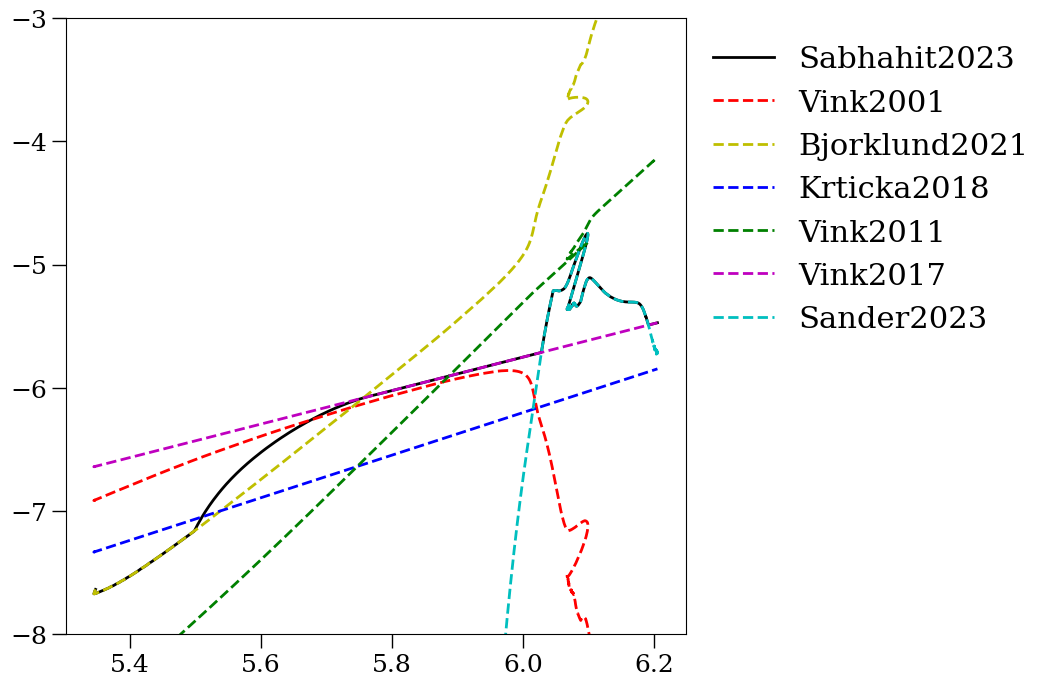

In [81]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.log10(wind_test_l), np.log10(full_winds), 'k-', label='Sabhahit2023')
ax.plot(np.log10(wind_test_l), np.log10(v01_winds), 'r--', label='Vink2001')
ax.plot(np.log10(wind_test_l), np.log10(b21_winds), 'y--', label='Bjorklund2021')
ax.plot(np.log10(wind_test_l), np.log10(k18_winds), 'b--', label='Krticka2018')
ax.plot(np.log10(wind_test_l), np.log10(v11_winds), 'g--', label='Vink2011')

ax.plot(np.log10(wind_test_l), np.log10(v17_winds), 'm--', label='Vink2017')
ax.plot(np.log10(wind_test_l), np.log10(s23_winds), 'c--', label='Sander2023')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

#ax.set_xlim(5.3, 6.2)
ax.set_ylim(-8, -3)

/tmp/ipykernel_279733/715505812.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.plot(wind_test_model, np.log10(s23_winds), 'c--', label='Sander2023', lw=1)


(-8.0, -3.0)

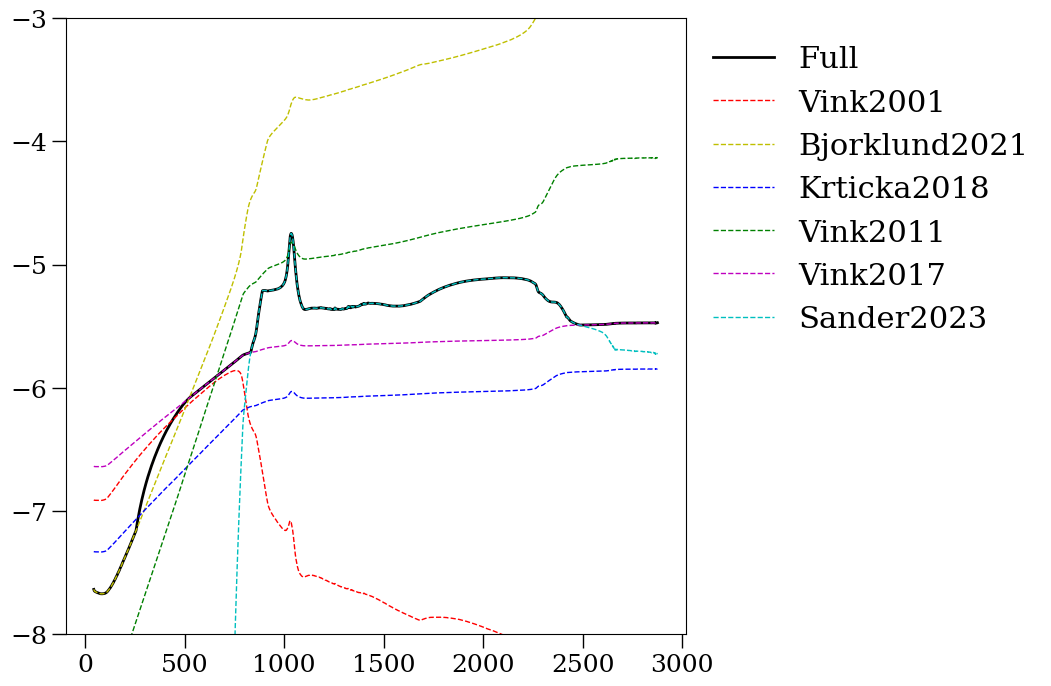

In [147]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(wind_test_model, np.log10(full_winds), 'k-', label='Full')
ax.plot(wind_test_model, np.log10(v01_winds), 'r--', label='Vink2001', lw=1)
ax.plot(wind_test_model, np.log10(b21_winds), 'y--', label='Bjorklund2021', lw=1)
ax.plot(wind_test_model, np.log10(k18_winds), 'b--', label='Krticka2018', lw=1)
ax.plot(wind_test_model, np.log10(v11_winds), 'g--', label='Vink2011', lw=1)

ax.plot(wind_test_model, np.log10(v17_winds), 'm--', label='Vink2017', lw=1)
ax.plot(wind_test_model, np.log10(s23_winds), 'c--', label='Sander2023', lw=1)
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

#ax.set_xlim(5.3, 6.2)
ax.set_ylim(-8, -3)

/tmp/ipykernel_279733/2748748892.py:7: RuntimeWarning: divide by zero encountered in log10
  ax.plot(wind_test_g, np.log10(s23_winds), 'c--', label='Sander2023')


(-10.0, -2.0)

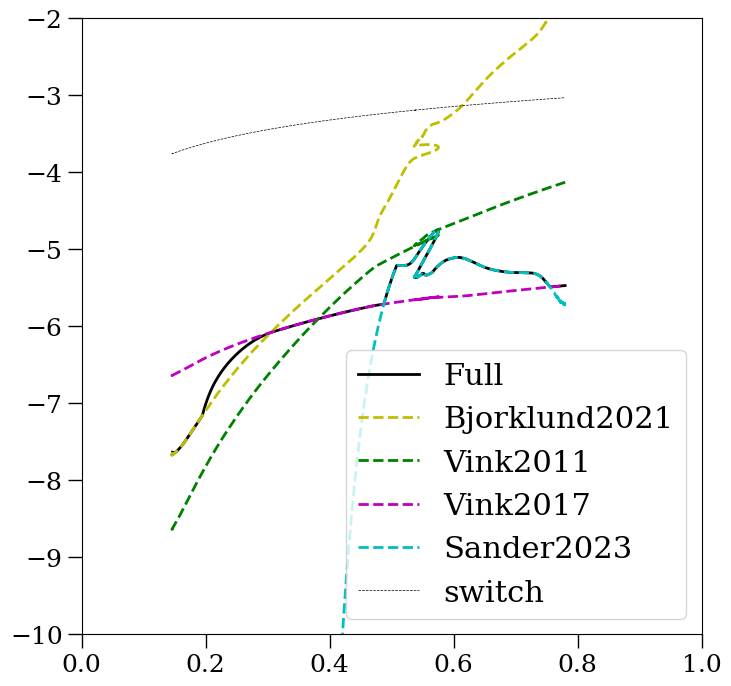

In [83]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(wind_test_g, np.log10(full_winds), 'k-', label='Full')
ax.plot(wind_test_g, np.log10(b21_winds), 'y--', label='Bjorklund2021')
ax.plot(wind_test_g, np.log10(v11_winds), 'g--', label='Vink2011')
ax.plot(wind_test_g, np.log10(v17_winds), 'm--', label='Vink2017')
ax.plot(wind_test_g, np.log10(s23_winds), 'c--', label='Sander2023')
ax.plot(wind_test_g, np.log10(wind_test_g/g_switch)-3, 'k--', lw=0.5, label='switch')
ax.legend()

ax.set_xlim(0, 1)
ax.set_ylim(-10, -2)

/tmp/ipykernel_279733/4240285076.py:7: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(wind_test_t), np.log10(s23_winds), 'c--', label='Sander2023')


(-10.0, -2.0)

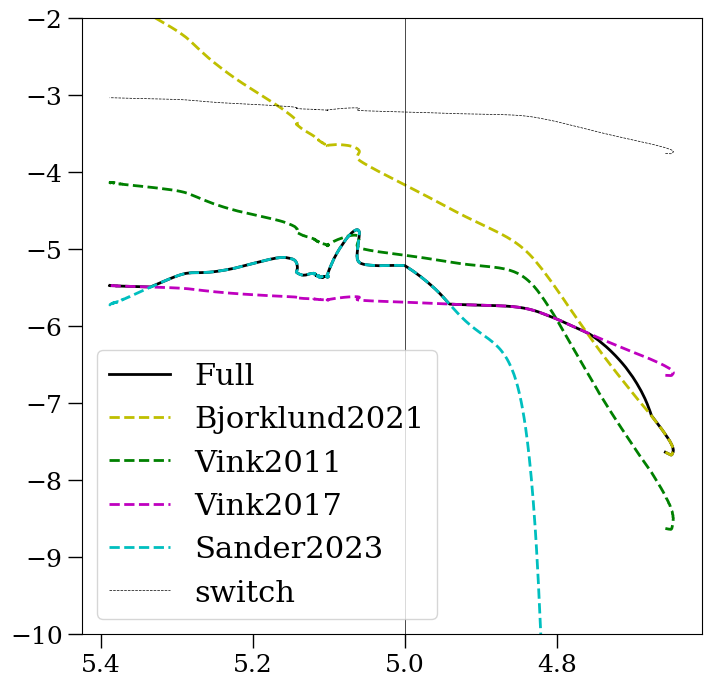

In [84]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.log10(wind_test_t), np.log10(full_winds), 'k-', label='Full')
ax.plot(np.log10(wind_test_t), np.log10(b21_winds), 'y--', label='Bjorklund2021')
ax.plot(np.log10(wind_test_t), np.log10(v11_winds), 'g--', label='Vink2011')
ax.plot(np.log10(wind_test_t), np.log10(v17_winds), 'm--', label='Vink2017')
ax.plot(np.log10(wind_test_t), np.log10(s23_winds), 'c--', label='Sander2023')
ax.plot(np.log10(wind_test_t), np.log10(wind_test_g/g_switch)-3, 'k--', lw=0.5, label='switch')
ax.invert_xaxis()
ax.legend()
ax.vlines(5, -10, -2, color='k', lw=0.5)

#ax.set_xlim(0, 1)
ax.set_ylim(-10, -2)

In [104]:
mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)

mesa_rotational_logmdot = np.log10(10.**mesa_wind_rot - 10.**mesa_wind)

In [101]:
mesa_rotational_mdot

array([-7.64224719, -7.59645757, -7.58198947, ..., -4.38810449,
       -4.64545021, -4.77322509])

In [98]:
min(wind_test_h.rotational_mdot_boost[wind_test_start_i:])

1.522191234168809

Text(0, 0.5, '$\\dot{M}_\\mathrm{rot}(i+1)/\\dot{M}_\\mathrm{rot}(i)$')

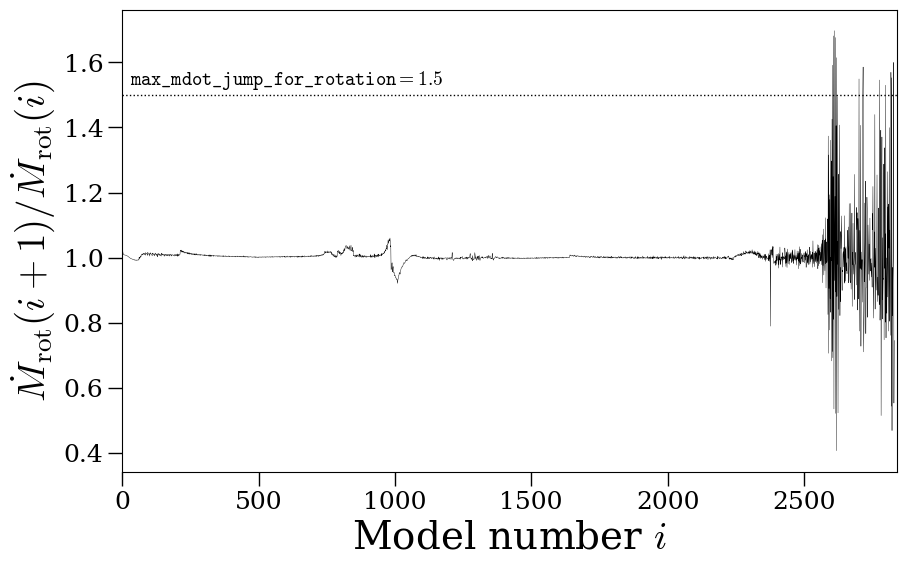

In [145]:
fig, ax = plt.subplots(figsize=(10, 6))

mdot_wind_jump = 10.**mesa_rotational_logmdot[1:]/10.**mesa_rotational_logmdot[:-1]
ax.plot(mdot_wind_jump, 'k-', lw=0.3)
ax.set_xlim(0, len(mdot_wind_jump)+10)

ax.hlines(1.5, 0, 3000, color='k', ls=':', lw=1)
ax.text(30, 1.51, '$\\tt{max\\_mdot\\_jump\\_for\\_rotation=1.5}$', ha='left', va='bottom', fontsize=14)

plt.xlabel('Model number $i$')
plt.ylabel('$\\dot{M}_\\mathrm{rot}(i+1)/\\dot{M}_\\mathrm{rot}(i)$')

In [86]:
10.**wind_test_h.log_abs_mdot[wind_test_start_i:]

array([4.31729445e-08, 4.84471478e-08, 4.89784394e-08, ...,
       4.19377749e-05, 2.38214556e-05, 1.80542102e-05])

In [87]:
wind_test_h.rotational_mdot_boost[wind_test_start_i:]

array([ 2.11813794,  2.09523309,  2.1485565 , ..., 41.0529065 ,
       19.87644059, 15.07760549])

/tmp/ipykernel_279733/1694462269.py:16: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)
/tmp/ipykernel_279733/1694462269.py:105: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


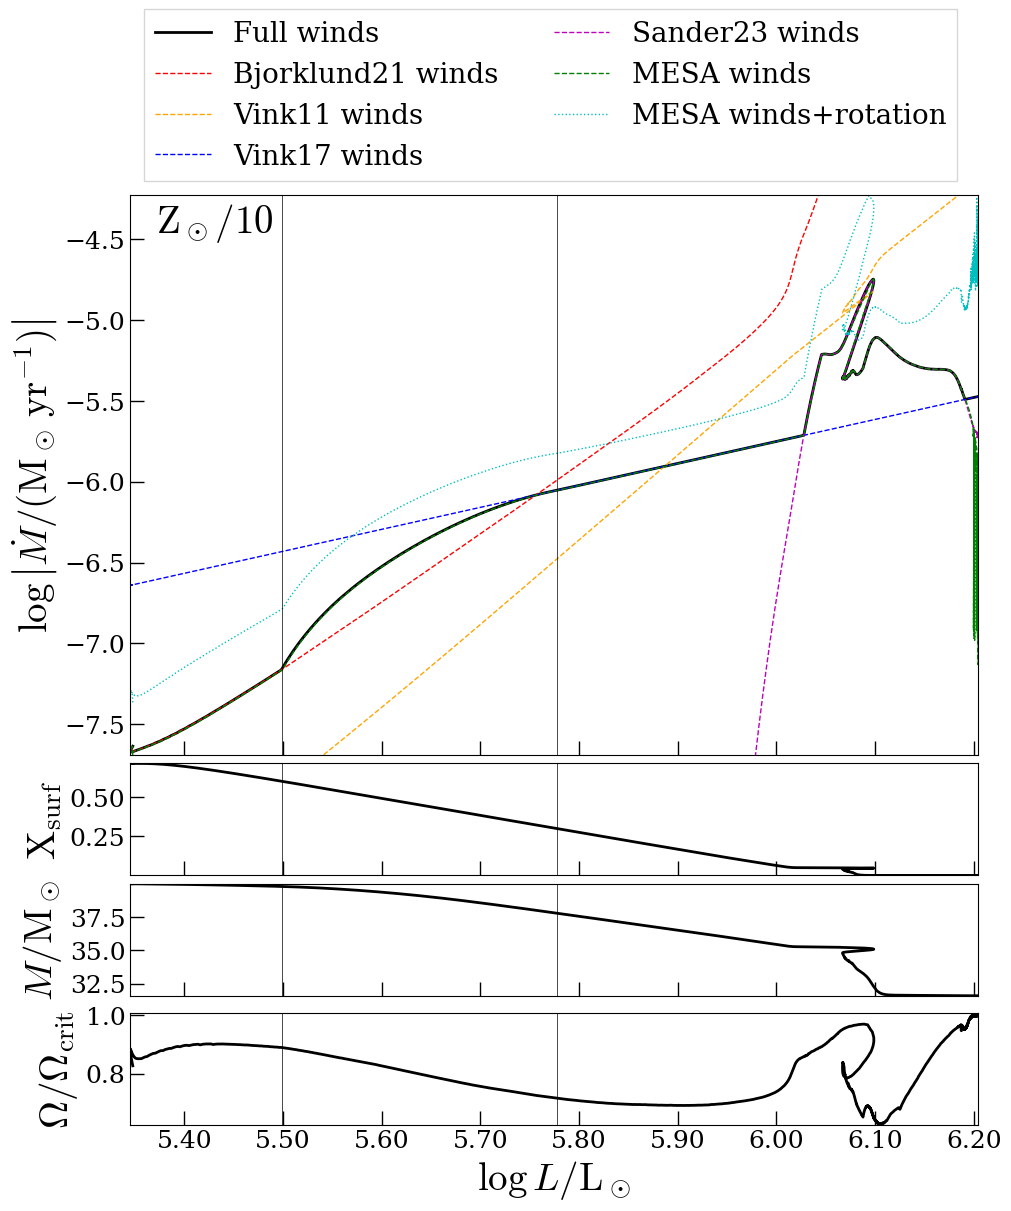

In [88]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'g--', label='MESA winds', lw=1)
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_m40_p060_zsun_div_10')

/tmp/ipykernel_279733/150139824.py:16: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)
/tmp/ipykernel_279733/150139824.py:105: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


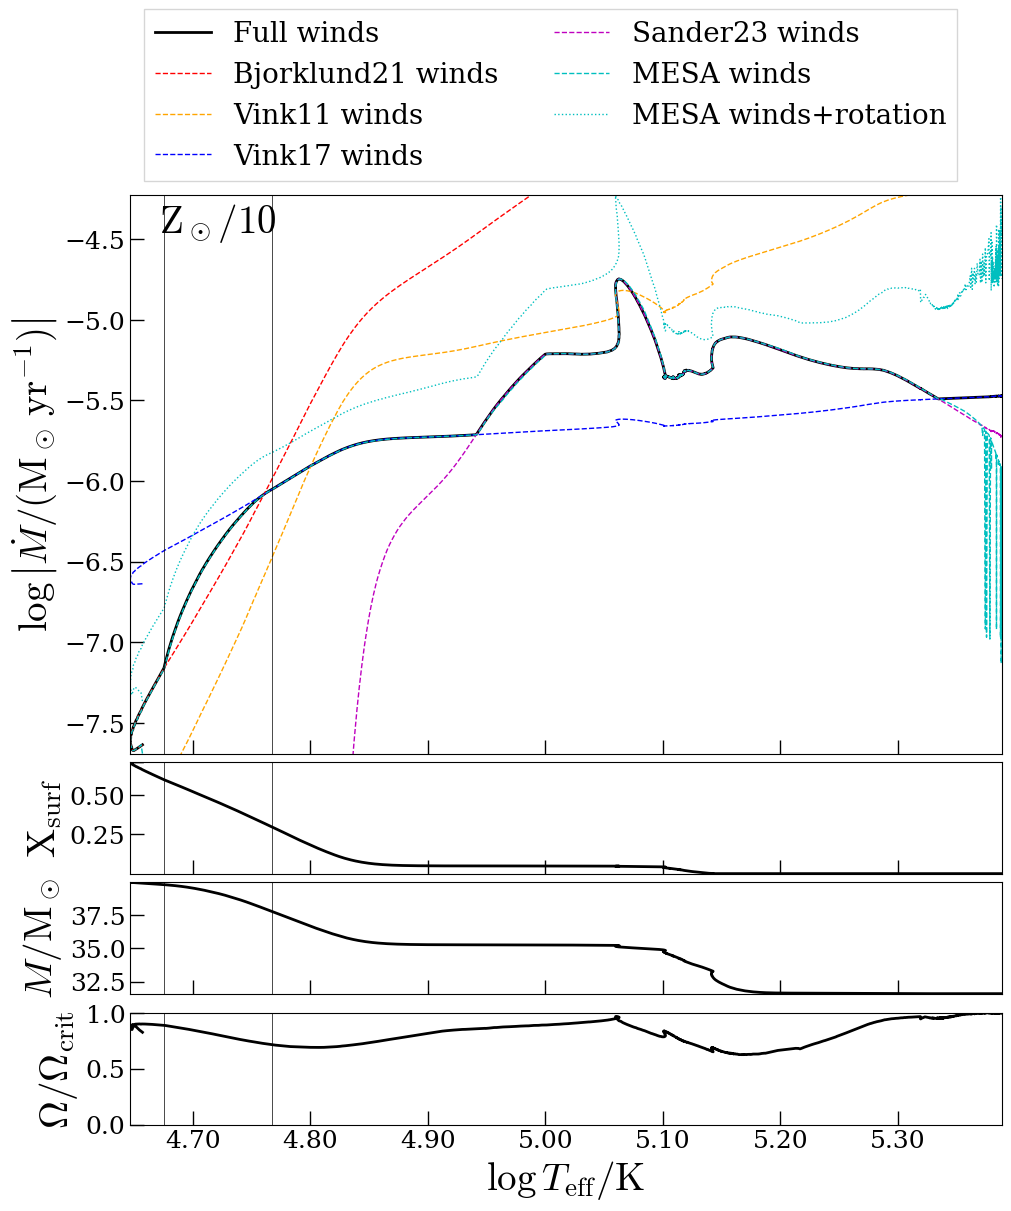

In [89]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_t)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_Teff[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(wind_test_h.log_Teff[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_Teff[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_Teff[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_Teff[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_Teff[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = 0
maxy = 1
ax3.plot(wind_test_h.log_Teff[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_teff_m40_p060_zsun_div_10')

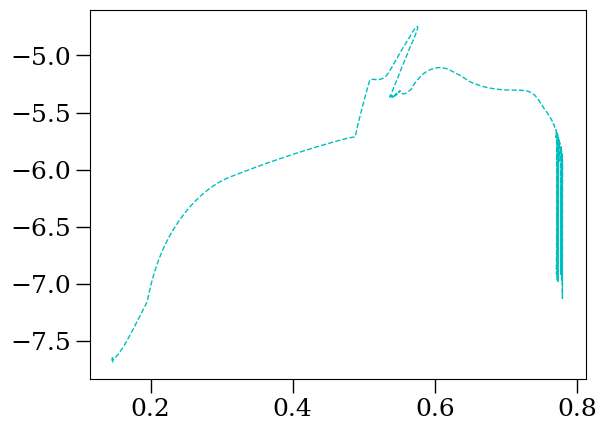

In [90]:
plt.plot(wind_test_g, mesa_wind, 'c--', label='MESA winds', lw=1)

/tmp/ipykernel_279733/509781572.py:16: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)
/tmp/ipykernel_279733/509781572.py:105: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


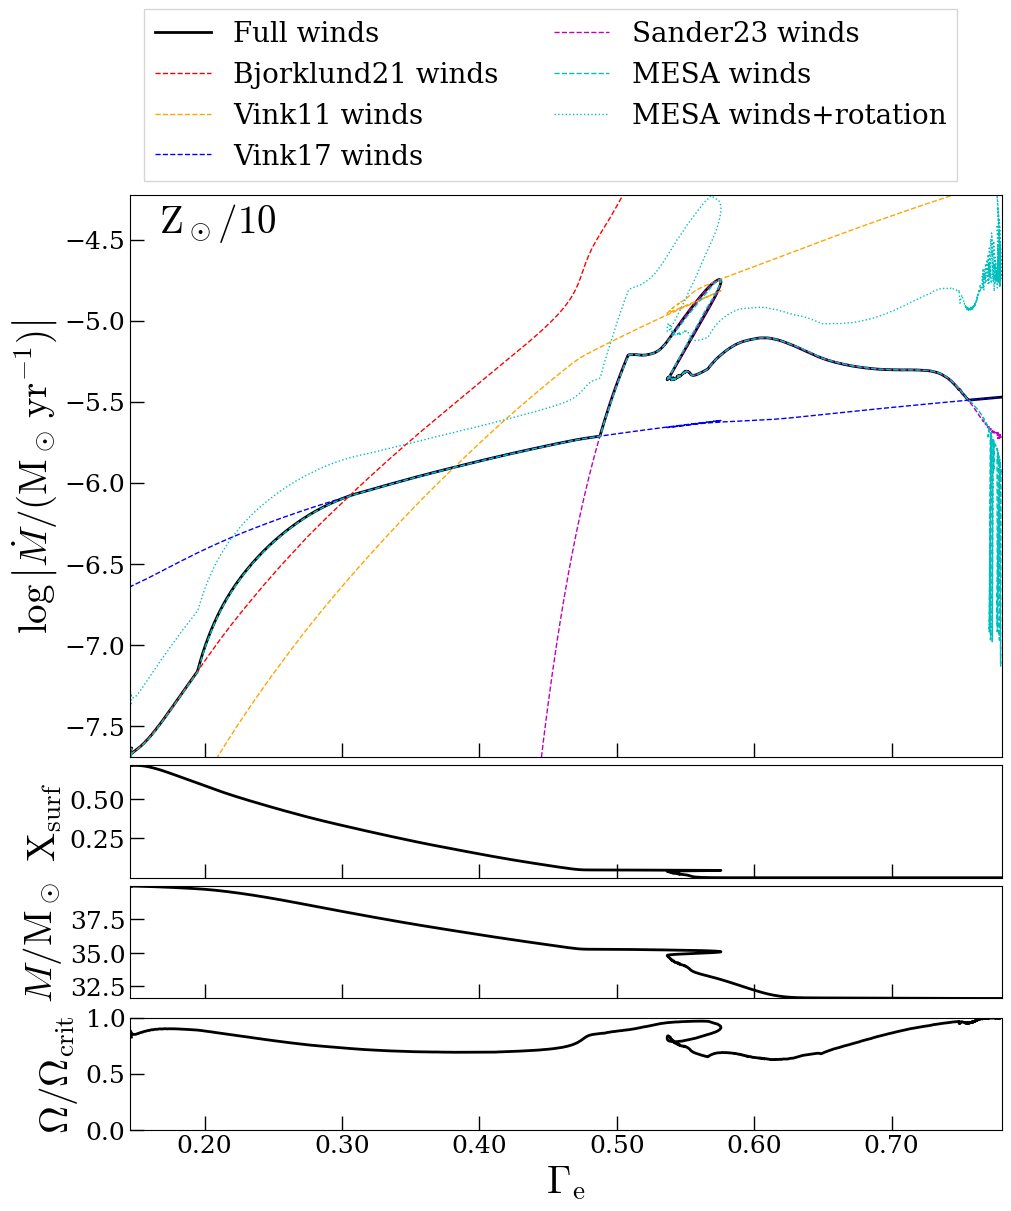

In [92]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = wind_test_g
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_g, mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(wind_test_g, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_g
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_g
except:
    y1_log_l = maxy + 1
    
#ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_g, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

#ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_g, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

#ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = 0
maxy = 1
ax3.plot(wind_test_g, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\Gamma_\\mathrm{e}$')

#ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_eddgamma_m40_p060_zsun_div_10')

In [37]:
def terminal_v(l, m, r, z, x):
    g_e = edd_gamma(x, l, m)
    m *= u.Msun
    r *= u.Rsun
    v = (2.6
         * np.sqrt((2*ct.G.cgs * m * (1-g_e))/r)
         * (z/Z_SUN)**0.2
         )
    v = v.to(u.cm/u.s)
    return v.value

def ter_esc_v_ratio(l, m, z, x):
    g_e = edd_gamma(x, l, m)
    ratio = 2.6 * np.sqrt(1-g_e) * (z/Z_SUN)**0.2
    return ratio

def wind_eta(mdot, l, m, r, z, x):
    mdot *= u.Msun/u.yr
    ter_v = terminal_v(l, m, r, z, x) * u.cm/u.s
    eta = (mdot * ter_v / (l*u.Lsun/ ct.c)).to(u.dimensionless_unscaled)
    return eta.value

def wind_f(l, m, z, x):
    v_ratio = ter_esc_v_ratio(l, m, z, x)
    f = 0.75/(1+v_ratio**-2)
    return f

In [38]:
test_wind_eta_b21 = wind_eta(
    b21_winds,
    wind_test_l,
    wind_test_m,
    wind_test_r,
    wind_test_z,
    wind_test_x
)

test_wind_eta_v01 = wind_eta(
    v01_winds,
    wind_test_l,
    wind_test_m,
    wind_test_r,
    wind_test_z,
    wind_test_x
)

test_wind_f = wind_f(
    wind_test_l,
    wind_test_m,
    wind_test_z,
    wind_test_x
)

Text(5.37, 1.05, 'Thick winds')

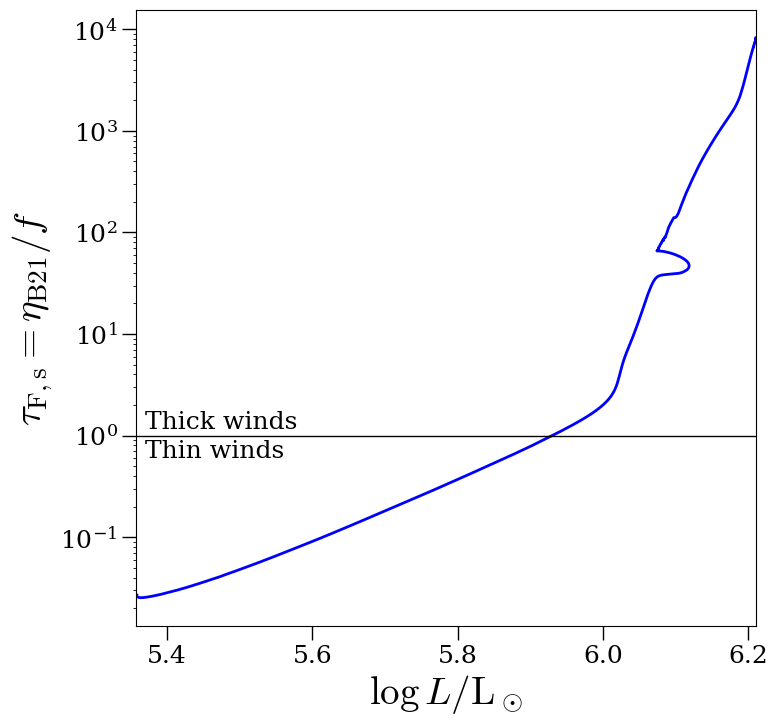

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.log10(wind_test_l), test_wind_eta_b21/test_wind_f, 'b-', label='$\\tau_\\mathrm{F,s}=\\frac{\\eta}{f}$')
ax.set_yscale('log')

ax.set_xlabel('$\\log L/\\mathrm{L}_\odot$')
ax.set_ylabel('$\\tau_\\mathrm{F,s}=\\eta_\\mathrm{B21}/f$')

ax.hlines(1, 5.3, 6.5, color='k', lw=1)
ax.set_xlim(min(np.log10(wind_test_l)), max(np.log10(wind_test_l)))

ax.text(5.37, 0.9, 'Thin winds', ha='left', va='top', fontsize=18)
ax.text(5.37, 1.05, 'Thick winds', ha='left', va='bottom', fontsize=18)

(0.01, 100)

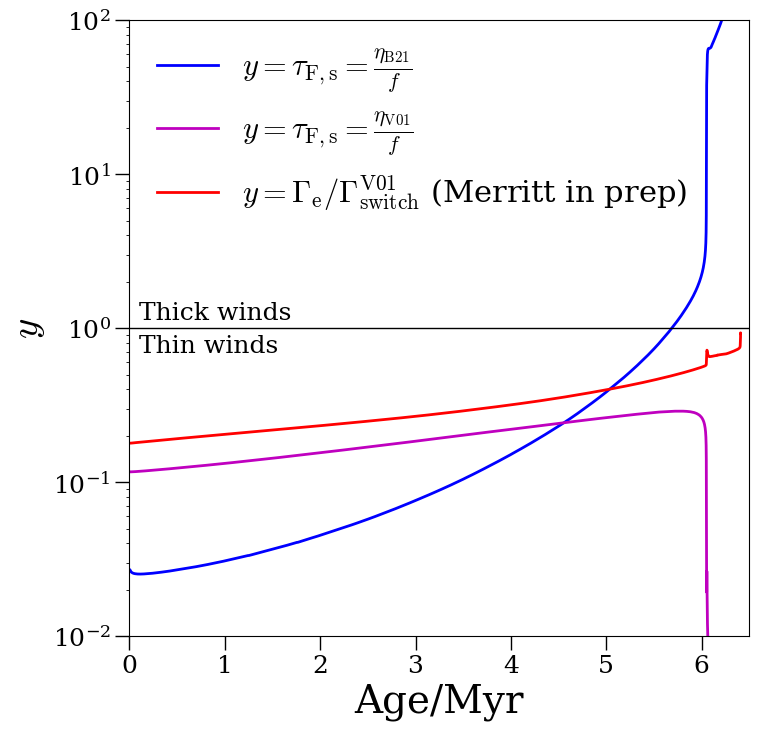

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(wind_test_age/1e6, test_wind_eta_b21/test_wind_f, 'b-', label='$y=\\tau_\\mathrm{F,s}=\\frac{\\eta_\\mathrm{B21}}{f}$')
ax.plot(wind_test_age/1e6, test_wind_eta_v01/test_wind_f, 'm-', label='$y=\\tau_\\mathrm{F,s}=\\frac{\\eta_\\mathrm{V01}}{f}$')
ax.plot(wind_test_age/1e6, wind_test_g/g_switch, 'r-', label='$y=\\Gamma_\\mathrm{e}/\\Gamma_\\mathrm{switch}^\\mathrm{V01}$ (Merritt in prep)')
ax.set_yscale('log')

ax.legend(frameon=False)

ax.set_xlabel('Age/Myr')
ax.set_ylabel('$y$')

ax.hlines(1, 0, 7, color='k', lw=1)
ax.set_xlim(0, 6.5)

ax.text(0.1, 0.9, 'Thin winds', ha='left', va='top', fontsize=18)
ax.text(0.1, 1.05, 'Thick winds', ha='left', va='bottom', fontsize=18)

ax.set_ylim(0.01, 100)

Text(0, 0.5, '$y$')

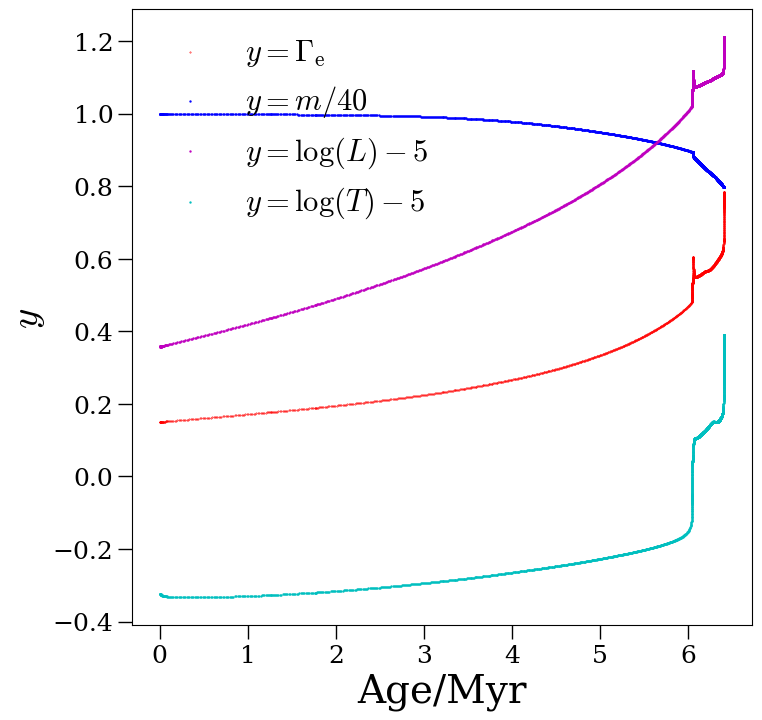

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(wind_test_age/1e6, wind_test_g, color='r', marker='.', label='$y=\\Gamma_\\mathrm{e}$', s=0.5)
ax.scatter(wind_test_age/1e6, wind_test_m/40, color='b', label='$y=m/40$', s=0.5)
ax.scatter(wind_test_age/1e6, np.log10(wind_test_l)-5, color='m', label='$y=\log (L)-5$', s=0.5)
#ax.scatter(wind_test_age/1e6, mesa_wind+6, color='g', label='$y=\log (\dot{M/})+6$', s=0.5)
ax.scatter(wind_test_age/1e6, np.log10(wind_test_t)-5, color='c', label='$y=\log (T)-5$', s=0.5)
#ax.set_yscale('log')

ax.legend(frameon=False)

ax.set_xlabel('Age/Myr')
ax.set_ylabel('$y$')


Text(0, 0.5, '$y$')

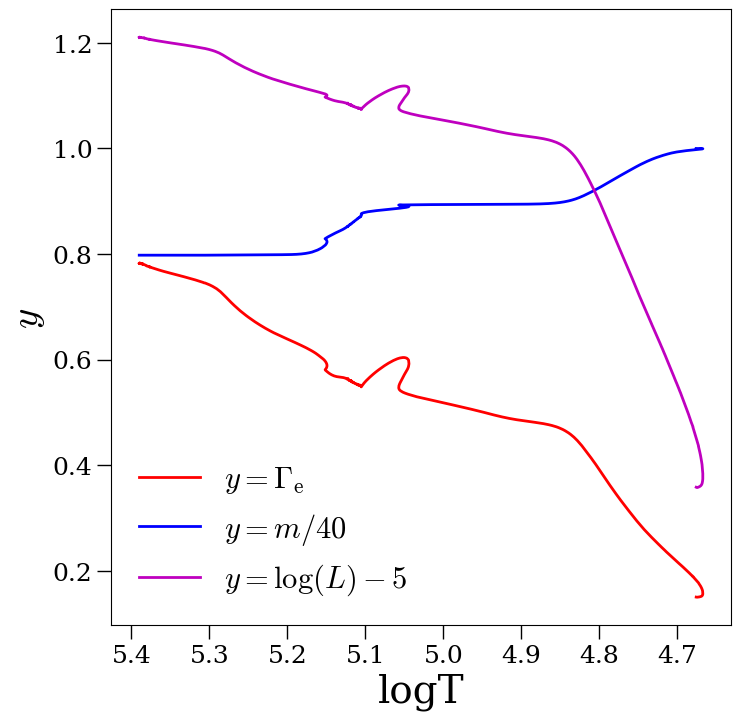

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.log10(wind_test_t), wind_test_g, color='r', label='$y=\\Gamma_\\mathrm{e}$')
ax.plot(np.log10(wind_test_t), wind_test_m/40, color='b', label='$y=m/40$')
ax.plot(np.log10(wind_test_t), np.log10(wind_test_l)-5, color='m', label='$y=\log (L)-5$')
#ax.plot(np.log10(wind_test_t), mesa_wind+6, color='g', label='$y=\log (\dot{M/})+6$')
#ax.plot(np.log10(wind_test_t), np.log10(wind_test_t)-5, color='c', label='$y=\log (T)-5$')
#ax.set_yscale('log')
ax.invert_xaxis()

ax.legend(frameon=False)

ax.set_xlabel('logT')
ax.set_ylabel('$y$')


# 200 Mo

In [43]:
wind_test_h = mr.MesaData(str(model_dicts[1]['200.0']['2.00']/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_z = np.tile([Z_SUN/10], len(wind_test_t))
wind_test_x = wind_test_h.surface_h1[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]

wind_test_age = wind_test_h.star_age[wind_test_start_i:]

b21_winds = np.array([
    bjorklund2021_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
    ])
v01_winds = np.array([
    vink2001_w(l, m, t, z) for l, m, t, z in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z)
])
v11_winds = np.array([
    vink2011_w(l, m, z) for l, m, z in zip(wind_test_l, wind_test_m, wind_test_z)
])
v17_winds = np.array([
    vink2017_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
s23_winds = np.array([
    sander2023_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
])
k18_winds = np.array([
    krticka2018_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
full_winds = np.array([
    winds(l, m, t, z, x, y) for l, m, t, z, x, y in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x, wind_test_y)
])

g_switch = np.array([
    sabhahit2023_switch_g(z) for z in wind_test_z
    ])

In [44]:
v01_winds_45kK = np.array([
    vink2001_w(l, m, 45000, z) for l, m, t, z in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z)
])

In [45]:
wind_test_g = edd_gamma(wind_test_x, wind_test_l, wind_test_m)

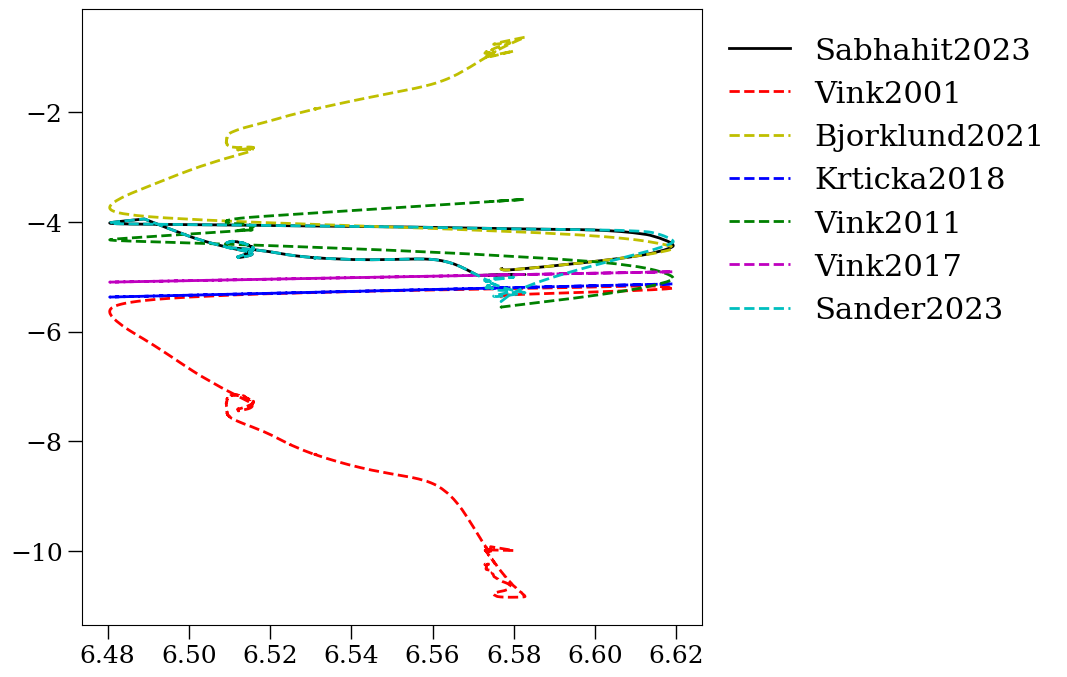

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.log10(wind_test_l), np.log10(full_winds), 'k-', label='Sabhahit2023')
ax.plot(np.log10(wind_test_l), np.log10(v01_winds), 'r--', label='Vink2001')
ax.plot(np.log10(wind_test_l), np.log10(b21_winds), 'y--', label='Bjorklund2021')
ax.plot(np.log10(wind_test_l), np.log10(k18_winds), 'b--', label='Krticka2018')
ax.plot(np.log10(wind_test_l), np.log10(v11_winds), 'g--', label='Vink2011')

ax.plot(np.log10(wind_test_l), np.log10(v17_winds), 'm--', label='Vink2017')
ax.plot(np.log10(wind_test_l), np.log10(s23_winds), 'c--', label='Sander2023')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

#ax.set_xlim(5.3, 6.2)
#ax.set_ylim(-10, -2)

(-10.0, -2.0)

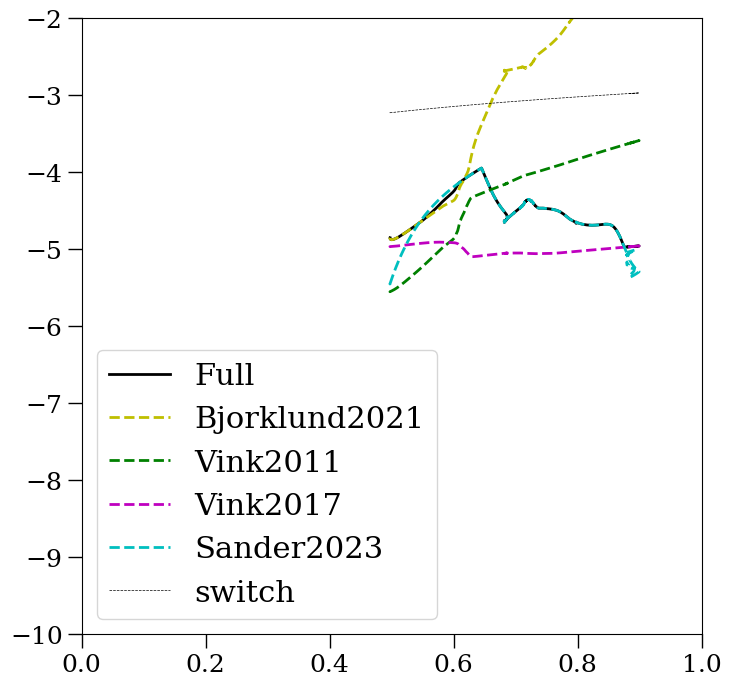

In [47]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(wind_test_g, np.log10(full_winds), 'k-', label='Full')
ax.plot(wind_test_g, np.log10(b21_winds), 'y--', label='Bjorklund2021')
ax.plot(wind_test_g, np.log10(v11_winds), 'g--', label='Vink2011')
ax.plot(wind_test_g, np.log10(v17_winds), 'm--', label='Vink2017')
ax.plot(wind_test_g, np.log10(s23_winds), 'c--', label='Sander2023')
ax.plot(wind_test_g, np.log10(wind_test_g/g_switch)-3, 'k--', lw=0.5, label='switch')
ax.legend()

ax.set_xlim(0, 1)
ax.set_ylim(-10, -2)

(-10.0, -2.0)

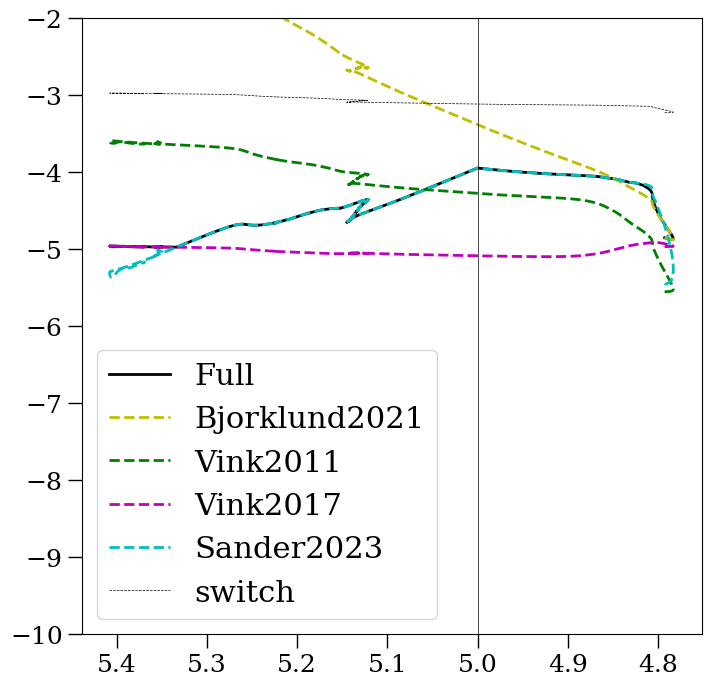

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.log10(wind_test_t), np.log10(full_winds), 'k-', label='Full')
ax.plot(np.log10(wind_test_t), np.log10(b21_winds), 'y--', label='Bjorklund2021')
ax.plot(np.log10(wind_test_t), np.log10(v11_winds), 'g--', label='Vink2011')
ax.plot(np.log10(wind_test_t), np.log10(v17_winds), 'm--', label='Vink2017')
ax.plot(np.log10(wind_test_t), np.log10(s23_winds), 'c--', label='Sander2023')
ax.plot(np.log10(wind_test_t), np.log10(wind_test_g/g_switch)-3, 'k--', lw=0.5, label='switch')
ax.invert_xaxis()
ax.legend()
ax.vlines(5, -10, -2, color='k', lw=0.5)

#ax.set_xlim(0, 1)
ax.set_ylim(-10, -2)

In [49]:
mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)

/tmp/ipykernel_4114904/787639034.py:105: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


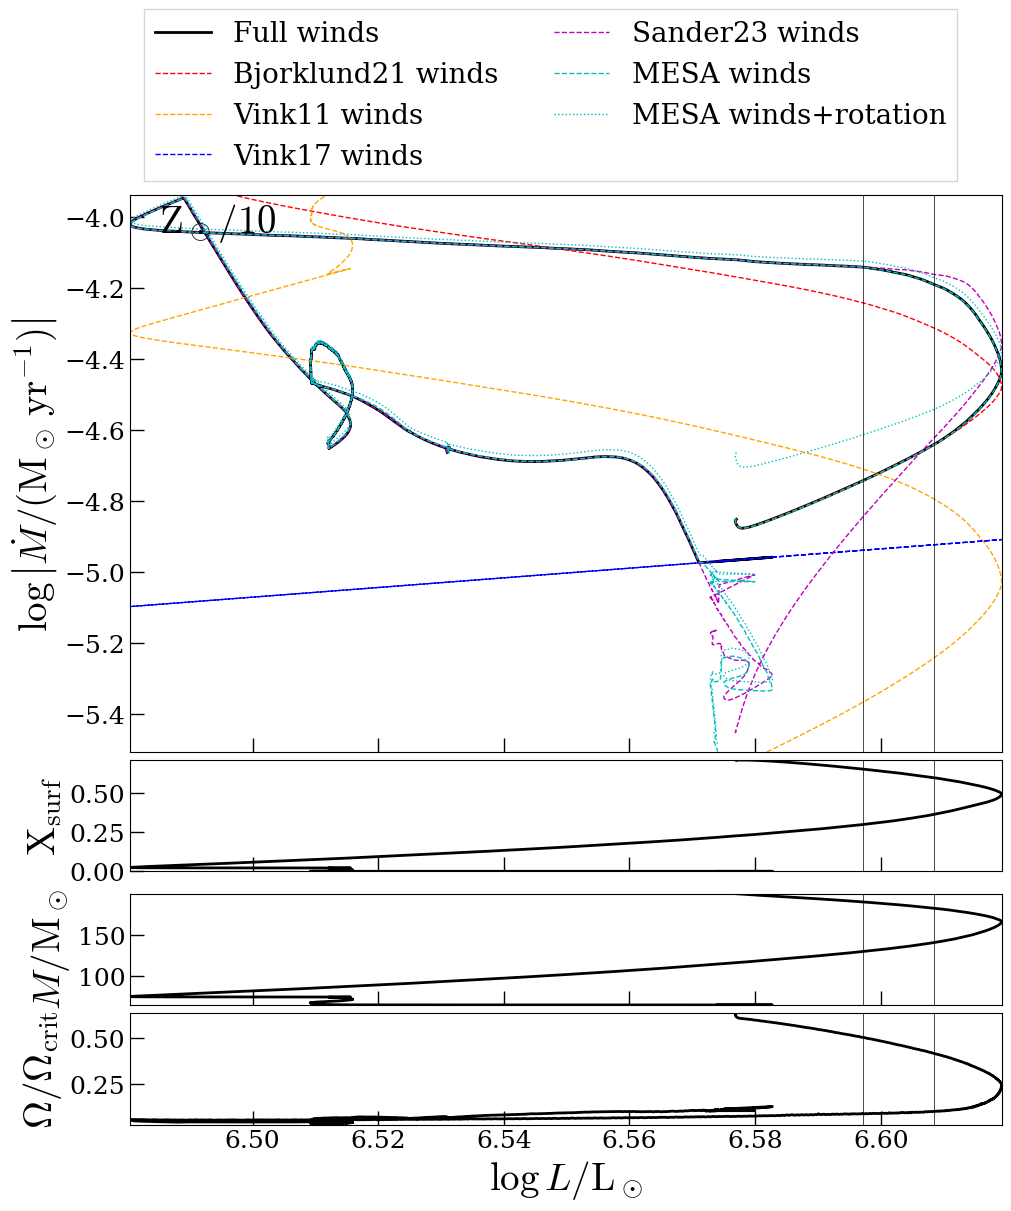

In [50]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_m40_p060_zsun_div_10')

/tmp/ipykernel_4114904/150139824.py:105: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


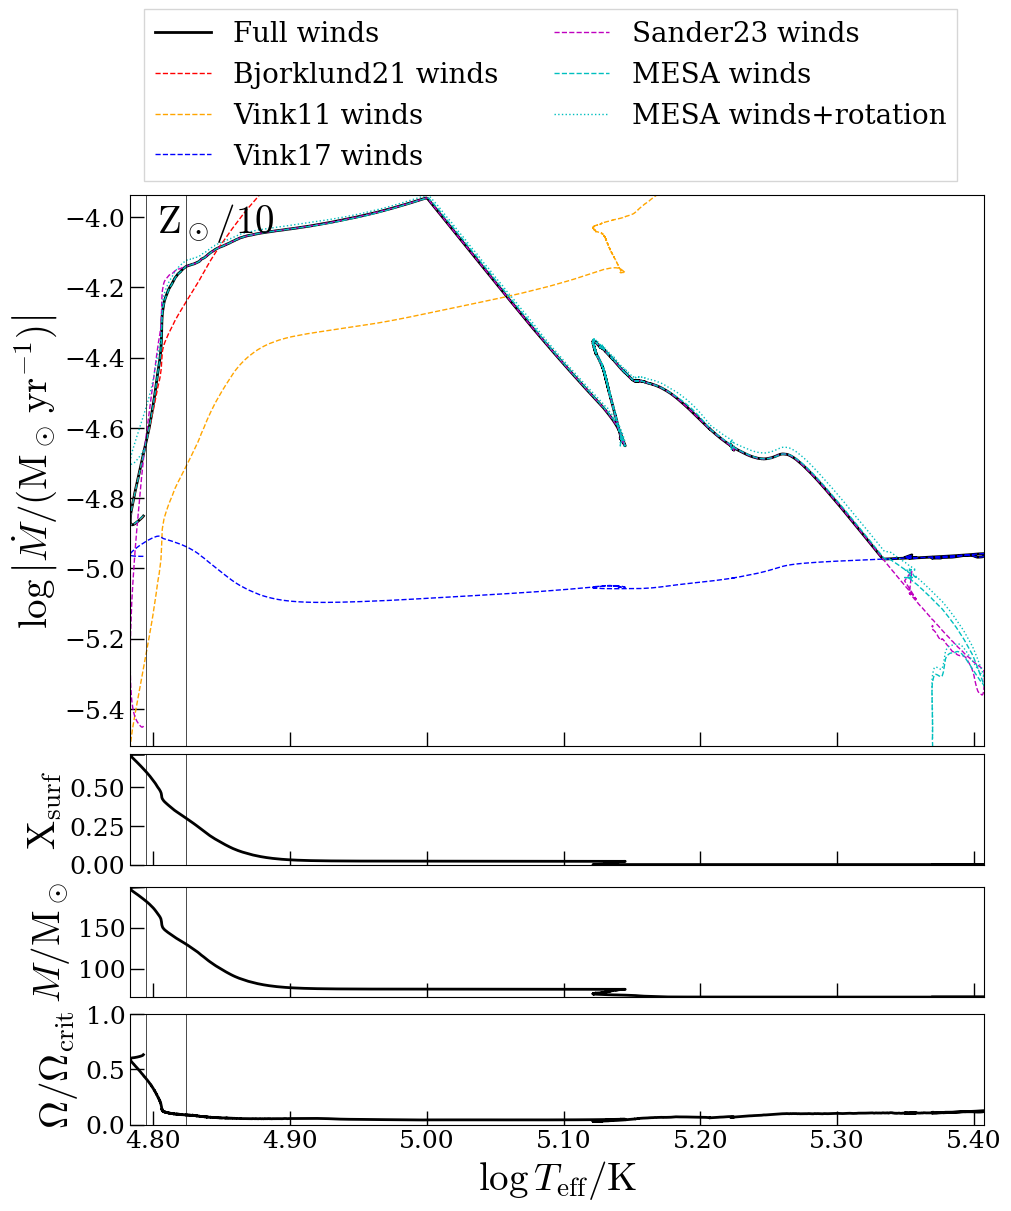

In [51]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_t)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_Teff[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(wind_test_h.log_Teff[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_Teff[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_Teff[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_Teff[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_Teff[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = 0
maxy = 1
ax3.plot(wind_test_h.log_Teff[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_teff_m40_p060_zsun_div_10')

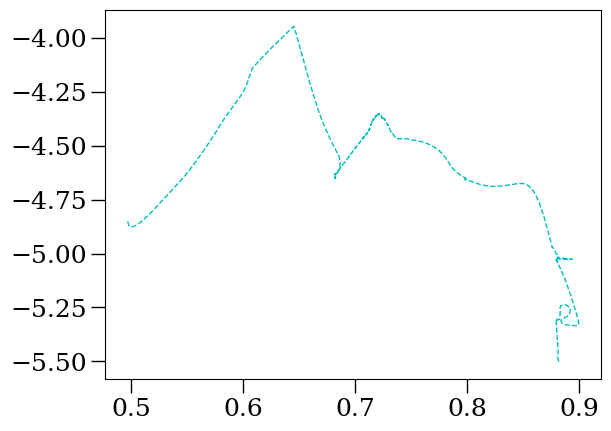

In [52]:
plt.plot(wind_test_g, mesa_wind, 'c--', label='MESA winds', lw=1)

/tmp/ipykernel_4114904/509781572.py:105: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


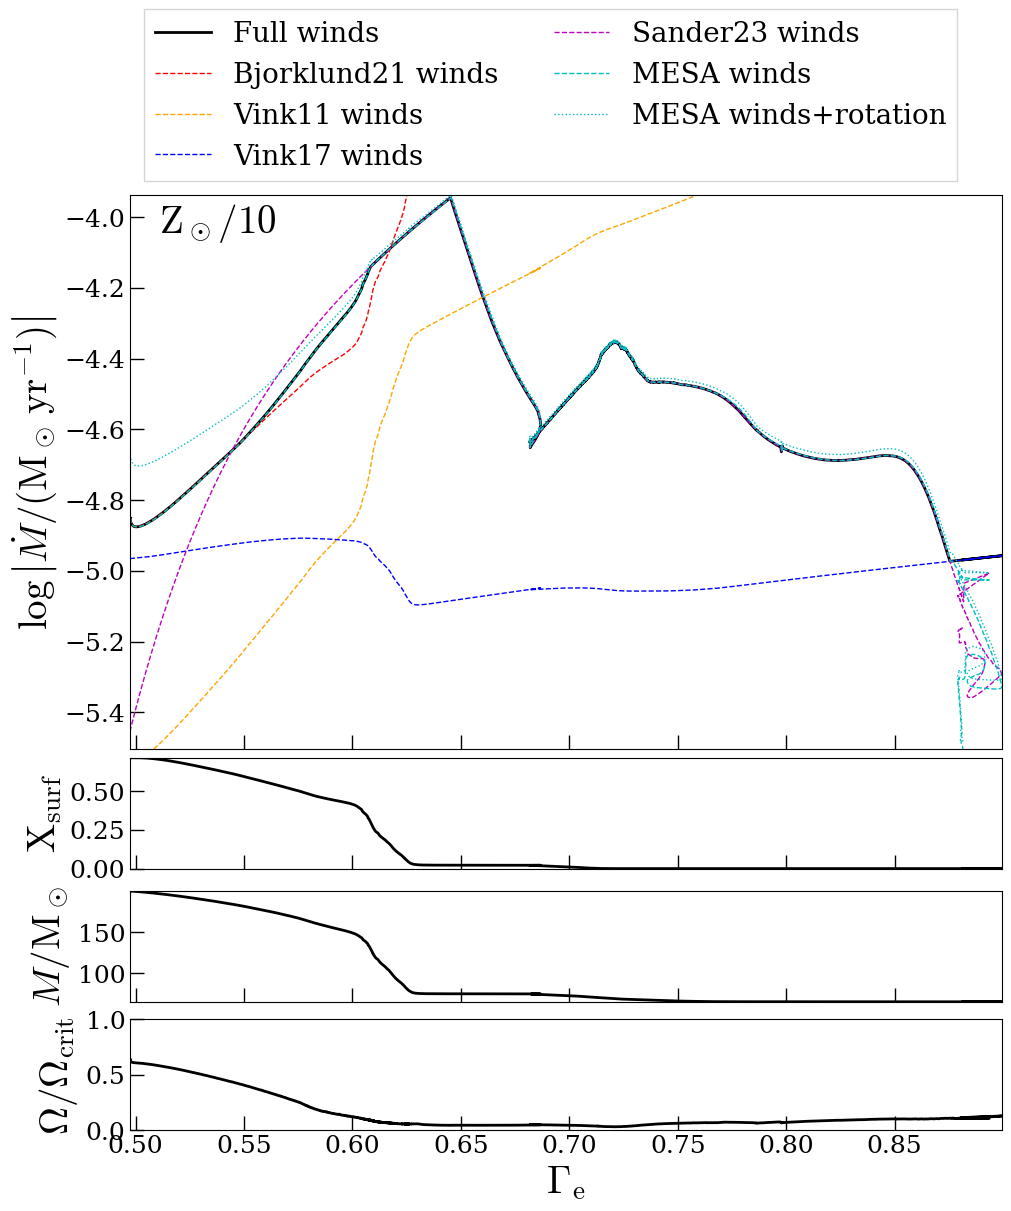

In [53]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = wind_test_g
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(b21_winds), 'r--', label='Bjorklund21 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sander23 winds', lw=1)

miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_g, mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(wind_test_g, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_g
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_g
except:
    y1_log_l = maxy + 1
    
#ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_g, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

#ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_g, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

#ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = 0
maxy = 1
ax3.plot(wind_test_g, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\Gamma_\\mathrm{e}$')

#ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_eddgamma_m40_p060_zsun_div_10')

In [54]:
def terminal_v(l, m, r, z, x):
    g_e = edd_gamma(x, l, m)
    m *= u.Msun
    r *= u.Rsun
    v = (2.6
         * np.sqrt((2*ct.G.cgs * m * (1-g_e))/r)
         * (z/Z_SUN)**0.2
         )
    v = v.to(u.cm/u.s)
    return v.value

def ter_esc_v_ratio(l, m, z, x):
    g_e = edd_gamma(x, l, m)
    ratio = 2.6 * np.sqrt(1-g_e) * (z/Z_SUN)**0.2
    return ratio

def wind_eta(mdot, l, m, r, z, x):
    mdot *= u.Msun/u.yr
    ter_v = terminal_v(l, m, r, z, x) * u.cm/u.s
    eta = (mdot * ter_v / (l*u.Lsun/ ct.c)).to(u.dimensionless_unscaled)
    return eta.value

def wind_f(l, m, z, x):
    v_ratio = ter_esc_v_ratio(l, m, z, x)
    f = 0.75/(1+v_ratio**-2)
    return f

In [55]:
test_wind_eta_b21 = wind_eta(
    b21_winds,
    wind_test_l,
    wind_test_m,
    wind_test_r,
    wind_test_z,
    wind_test_x
)

test_wind_eta_k18 = wind_eta(
    k18_winds,
    wind_test_l,
    wind_test_m,
    wind_test_r,
    wind_test_z,
    wind_test_x
)

test_wind_eta_v01 = wind_eta(
    v01_winds,
    wind_test_l,
    wind_test_m,
    wind_test_r,
    wind_test_z,
    wind_test_x
)

test_wind_f = wind_f(
    wind_test_l,
    wind_test_m,
    wind_test_z,
    wind_test_x
)

(0.1, 10)

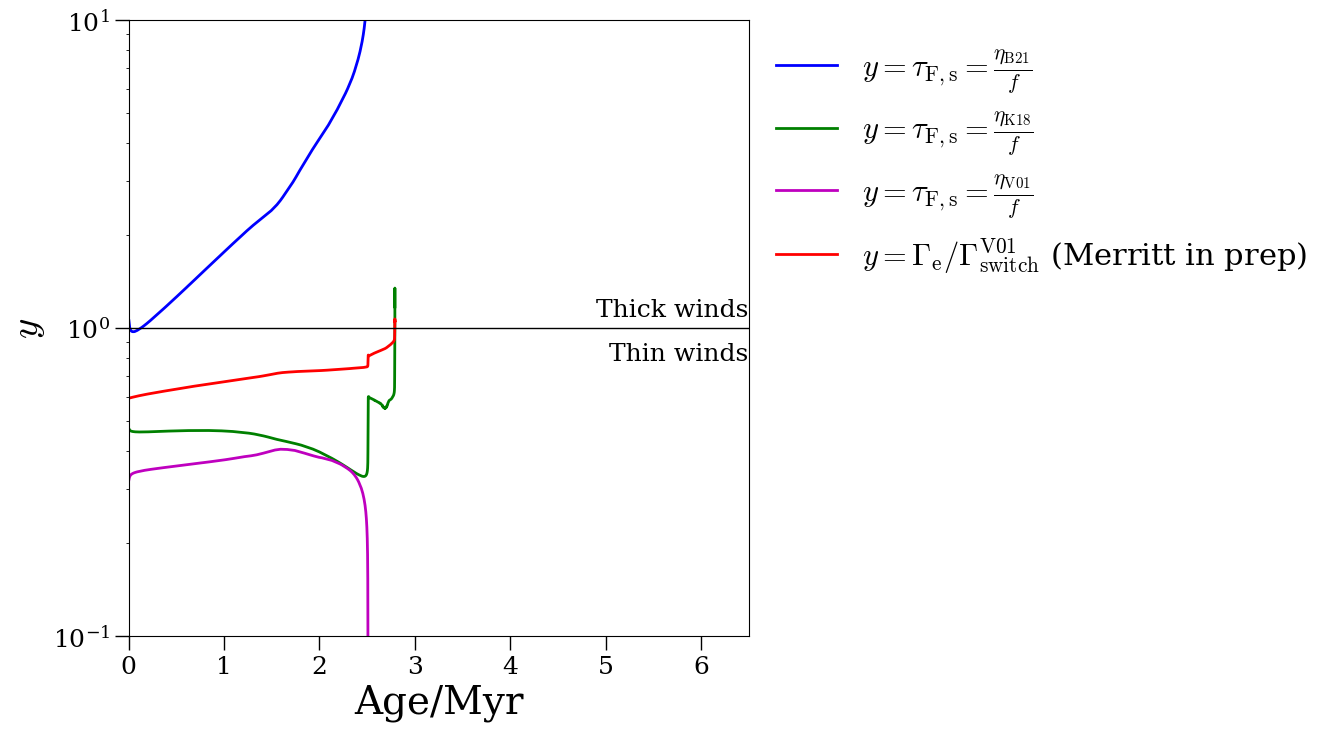

In [56]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(wind_test_age/1e6, test_wind_eta_b21/test_wind_f, 'b-', label='$y=\\tau_\\mathrm{F,s}=\\frac{\\eta_\\mathrm{B21}}{f}$')
ax.plot(wind_test_age/1e6, test_wind_eta_k18/test_wind_f, 'g-', label='$y=\\tau_\\mathrm{F,s}=\\frac{\\eta_\\mathrm{K18}}{f}$')
ax.plot(wind_test_age/1e6, test_wind_eta_v01/test_wind_f, 'm-', label='$y=\\tau_\\mathrm{F,s}=\\frac{\\eta_\\mathrm{V01}}{f}$')
ax.plot(wind_test_age/1e6, wind_test_g/g_switch, 'r-', label='$y=\\Gamma_\\mathrm{e}/\\Gamma_\\mathrm{switch}^\\mathrm{V01}$ (Merritt in prep)')
ax.set_yscale('log')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ax.set_xlabel('Age/Myr')
ax.set_ylabel('$y$')

ax.hlines(1, 0, 7, color='k', lw=1)
ax.set_xlim(0, 6.5)

ax.text(6.5, 0.9, 'Thin winds', ha='right', va='top', fontsize=18)
ax.text(6.5, 1.05, 'Thick winds', ha='right', va='bottom', fontsize=18)

ax.set_ylim(0.1, 10)

Text(0, 0.5, '$y$')

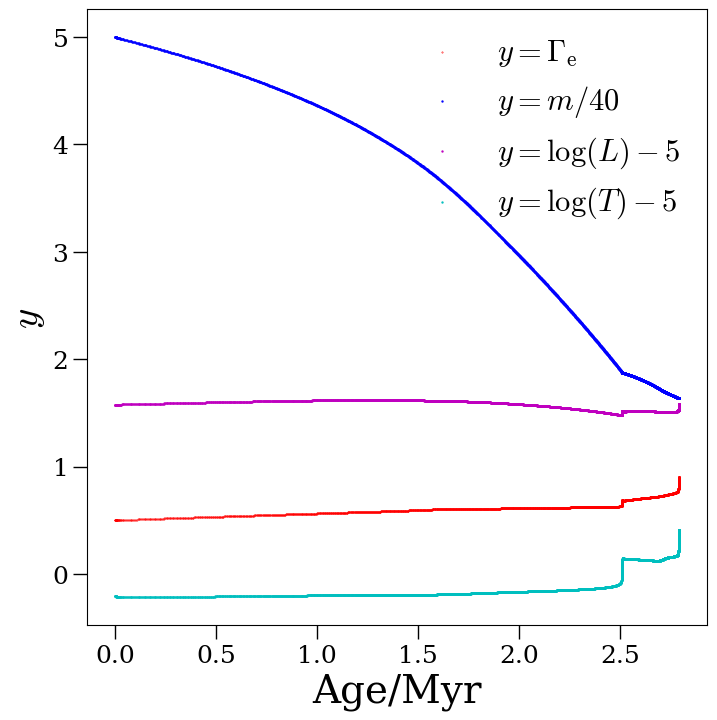

In [57]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(wind_test_age/1e6, wind_test_g, color='r', marker='.', label='$y=\\Gamma_\\mathrm{e}$', s=0.5)
ax.scatter(wind_test_age/1e6, wind_test_m/40, color='b', label='$y=m/40$', s=0.5)
ax.scatter(wind_test_age/1e6, np.log10(wind_test_l)-5, color='m', label='$y=\log (L)-5$', s=0.5)
#ax.scatter(wind_test_age/1e6, mesa_wind+6, color='g', label='$y=\log (\dot{M/})+6$', s=0.5)
ax.scatter(wind_test_age/1e6, np.log10(wind_test_t)-5, color='c', label='$y=\log (T)-5$', s=0.5)
#ax.set_yscale('log')

ax.legend(frameon=False)

ax.set_xlabel('Age/Myr')
ax.set_ylabel('$y$')


Text(0, 0.5, '$y$')

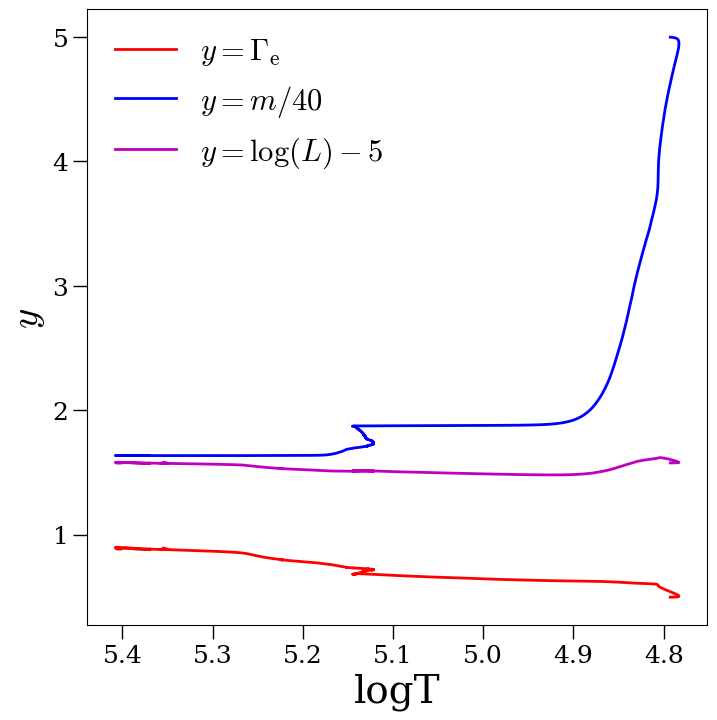

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.log10(wind_test_t), wind_test_g, color='r', label='$y=\\Gamma_\\mathrm{e}$')
ax.plot(np.log10(wind_test_t), wind_test_m/40, color='b', label='$y=m/40$')
ax.plot(np.log10(wind_test_t), np.log10(wind_test_l)-5, color='m', label='$y=\log (L)-5$')
#ax.plot(np.log10(wind_test_t), mesa_wind+6, color='g', label='$y=\log (\dot{M/})+6$')
#ax.plot(np.log10(wind_test_t), np.log10(wind_test_t)-5, color='c', label='$y=\log (T)-5$')
#ax.set_yscale('log')
ax.invert_xaxis()

ax.legend(frameon=False)

ax.set_xlabel('logT')
ax.set_ylabel('$y$')
